In [1]:
%matplotlib inline

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import wfdb
import ast

In [2]:
import os

In [3]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [4]:
path='C:/TheCave/work-stuff/ECG/Datasets/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(os.path.join(path,'ptbxl_database.csv'), index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


In [5]:
Y.scp_codes 

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21799, dtype: object

In [6]:
Y.scp_codes.shape

(21799,)

In [7]:
X = load_raw_data(Y, sampling_rate, path)


In [8]:
agg_df = pd.read_csv(os.path.join(path,'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]


In [9]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [10]:
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [11]:
test_fold = 10

X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [12]:
X_train.shape

(19601, 1000, 12)

In [13]:
y_train.head

<bound method NDFrame.head of ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 19601, dtype: object>

In [14]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 19601 entries, 1 to 21837
Series name: diagnostic_superclass
Non-Null Count  Dtype 
--------------  ----- 
19601 non-null  object
dtypes: object(1)
memory usage: 306.3+ KB


In [15]:
np.unique(y_train).shape[0]


28

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train_encoded = pd.DataFrame(mlb.fit_transform(y_train), columns=mlb.classes_)

In [17]:
y_train_encoded.shape

(19601, 5)

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
standard_scaler=StandardScaler()
num_sample,time_stamps,lead_ecg=X_train.shape

In [20]:
X_train_new=X_train.reshape(num_sample,-1)
standard_scaler.fit_transform(X_train_new)

array([[-0.63699445, -0.25904753,  0.31693273, ...,  0.40698747,
        -0.14975585, -0.42330522],
       [ 0.02834186,  0.68852979,  0.65826793, ..., -0.91570464,
        -0.79910897, -0.50410628],
       [-0.150163  , -0.37688098, -0.23407982, ..., -0.00946991,
        -0.0934344 , -0.01606787],
       ...,
       [ 0.21225596,  0.12882091, -0.06341222, ..., -0.54323924,
        -0.38166768,  0.07119727],
       [-0.30162168, -0.26886698,  0.00485482, ...,  0.60641777,
         1.20527184, -0.06454851],
       [-0.25834777, -0.11175572,  0.12188404, ...,  0.29847393,
         0.1219123 , -0.3683605 ]])

In [21]:
# X_train=X_train_new.reshape(num_sample,time_stamps,lead_ecg)

In [22]:
from sklearn.decomposition import PCA
pca=PCA(n_components=3)
X_pca=pca.fit_transform(X_train_new)

In [65]:
X_train_new.shape

(19601, 12000)

In [23]:
X_pca

array([[ 0.16782382, -0.18961639,  0.05804079],
       [ 0.12314067, -0.88762323,  1.3128921 ],
       [ 0.33106334, -1.7557642 ,  0.30224978],
       ...,
       [ 0.09620096,  0.00651111, -0.06639984],
       [ 0.09021242, -0.15938162,  0.20229545],
       [ 0.00641119, -1.09571225,  0.47571206]])

In [24]:
X_pca.shape

(19601, 3)

In [25]:
y_train_encoded.shape

(19601, 5)

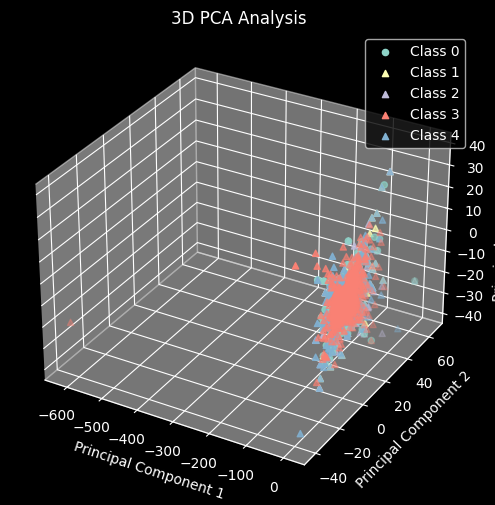

In [26]:

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for class_label in range(y_train_encoded.shape[1]):
    indices = np.where(np.asarray(y_train_encoded)[:, class_label] == 1)
    marker = 'o' if class_label == 0 else '^'  # Use different markers for each class
    ax.scatter(X_pca[indices, 0], X_pca[indices, 1], X_pca[indices, 2], marker=marker, label=f'Class {class_label}')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Analysis ')
ax.legend()

plt.show()

In [27]:
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio for each component: {explained_variance_ratio}")
print(f"Total explained variance: {np.sum(explained_variance_ratio)}")


Explained variance ratio for each component: [0.03001559 0.01567525 0.01058881]
Total explained variance: 0.056279653088164586


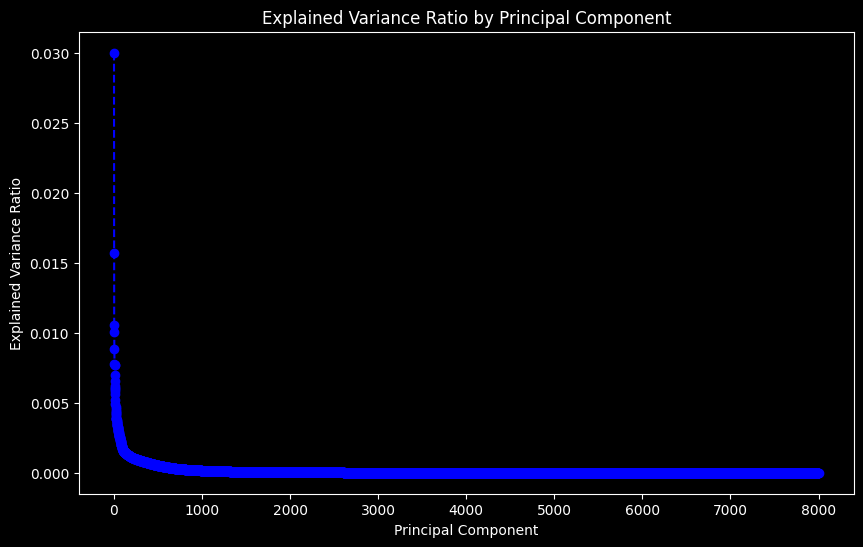

In [28]:
from sklearn.decomposition import IncrementalPCA


# Define batch size
batch_size = 8000  # Adjust this according to your memory constraints

# Initialize IncrementalPCA with a large number of components
n_components = 900  # Number of features as initial guess
ipca = IncrementalPCA()

# Fit IncrementalPCA on data in batches
for start in range(0, X_train_new.shape[0], batch_size):
    end = min(start + batch_size, X_train_new.shape[0])
    X_batch = X_train_new[start:end]
    ipca.partial_fit(X_batch)

# Explained variance ratio
explained_variance_ratio = ipca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', color='b')
plt.title('Explained Variance Ratio by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

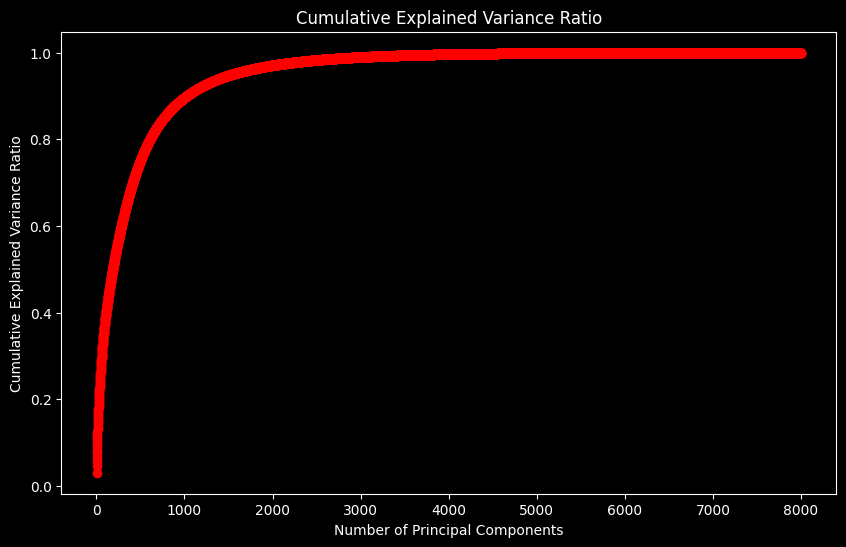

Number of components needed to explain 95.0% of variance: 1537


In [29]:
# Plot cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='--', color='r')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

# Determine the number of components needed to explain a certain variance threshold
variance_threshold = 0.95
n_components_needed = np.argmax(cumulative_explained_variance_ratio >= variance_threshold) + 1
print(f"Number of components needed to explain {variance_threshold*100}% of variance: {n_components_needed}")

In [31]:
def plot_ecg_samples(X, y, class_names, num_samples=3):
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_indices = np.where(np.asarray(y)[:, i] == 1)[0]  # Find indices of the class
        for j in range(num_samples):
            idx = class_indices[j]  # Get the sample index
            ecg_signal = X[idx, :, 0]  # Plot the signal of the first channel
            axes[i, j].plot(ecg_signal)
            axes[i, j].set_title(f'{class_name} - Sample {j+1}')
            axes[i, j].set_xlabel('Time Steps')
            axes[i, j].set_ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

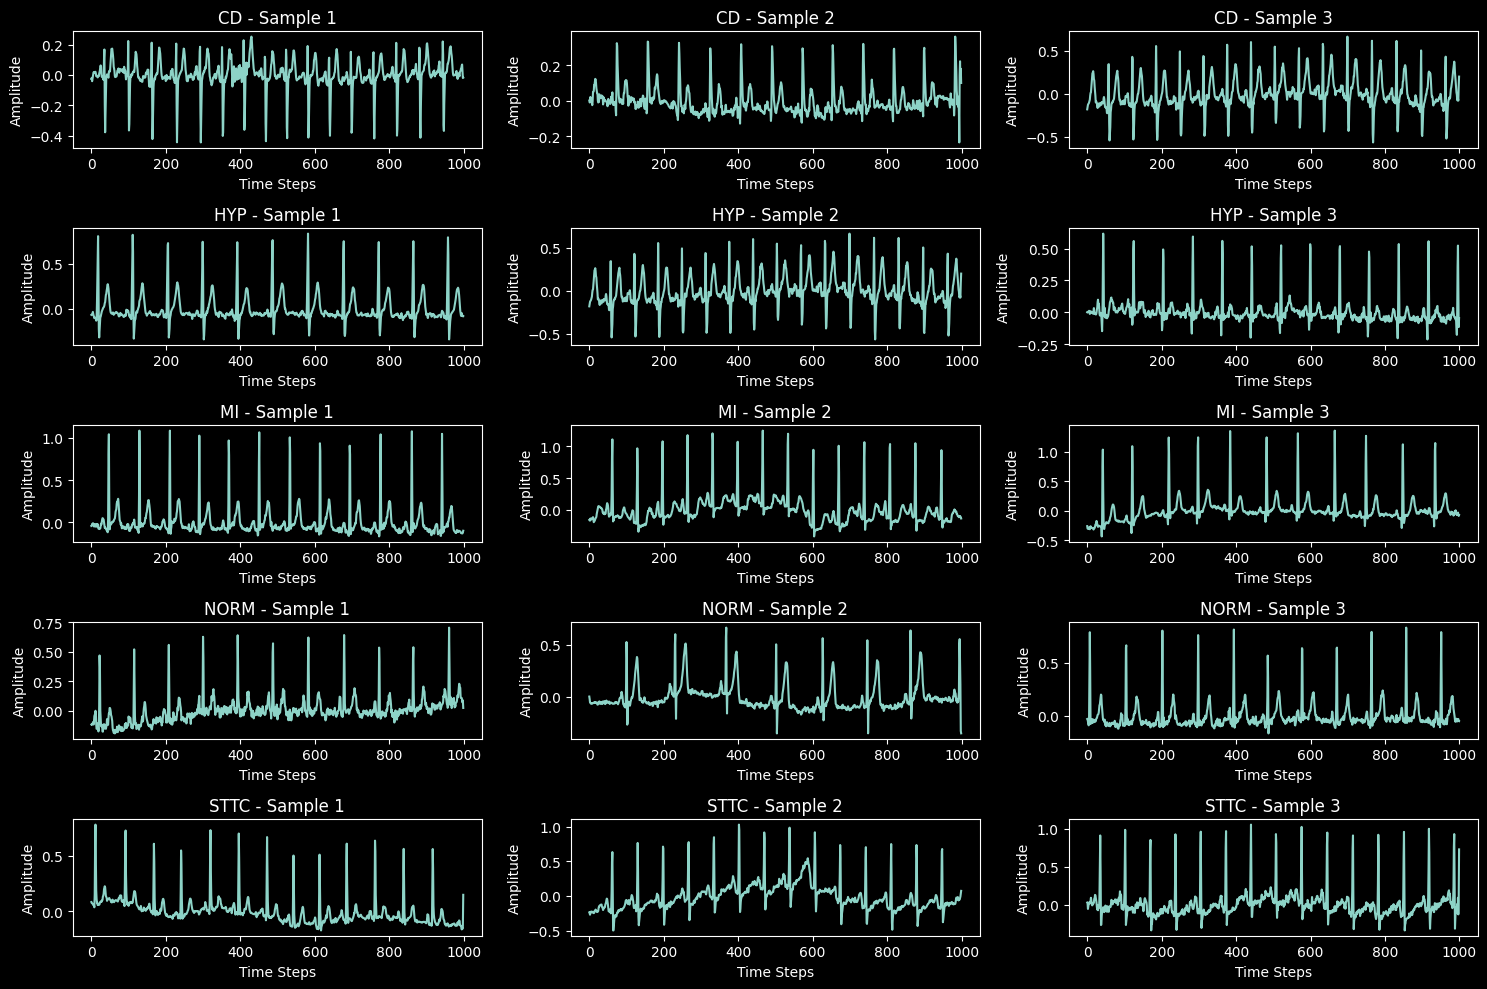

In [32]:
class_names = y_train_encoded.columns
plot_ecg_samples(X_train, y_train_encoded, class_names)

### Plotting all channels and classes for better visual understanding 

Classes : 

- Normal ECG: Healthy, normal heart activity.
- Conduction Disturbance: Problems with the electrical impulses that control heartbeats, including blocks and delays in conduction (e.g., bundle branch blocks).
- Hypertrophy: Enlargement of the heart muscles, typically due to high blood pressure or other cardiovascular conditions.
- Myocardial Infarction: ECG patterns indicative of a past or ongoing heart attack
- ST/T Changes: Abnormalities in the ST segment or T waves, often indicating ischemia, infarction, or other cardiac issues

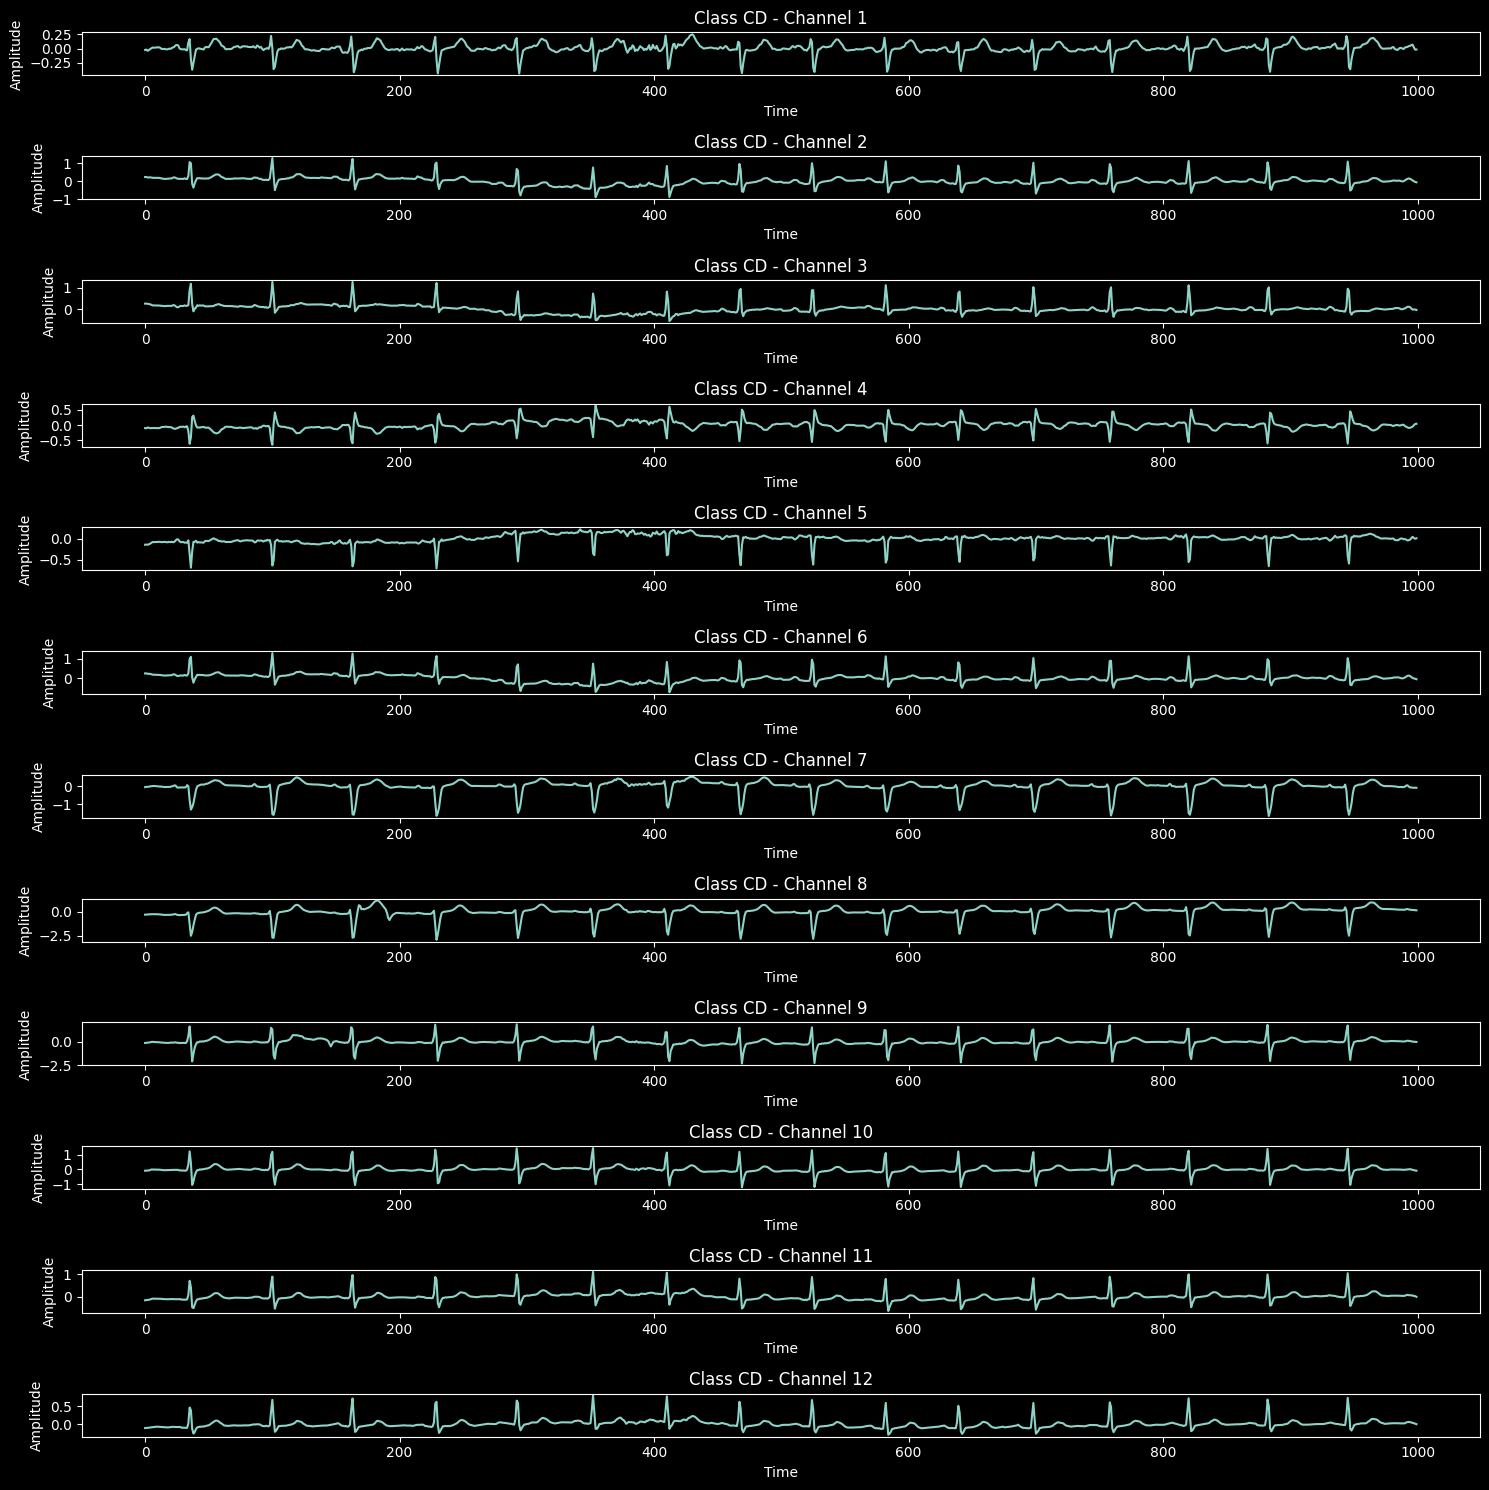

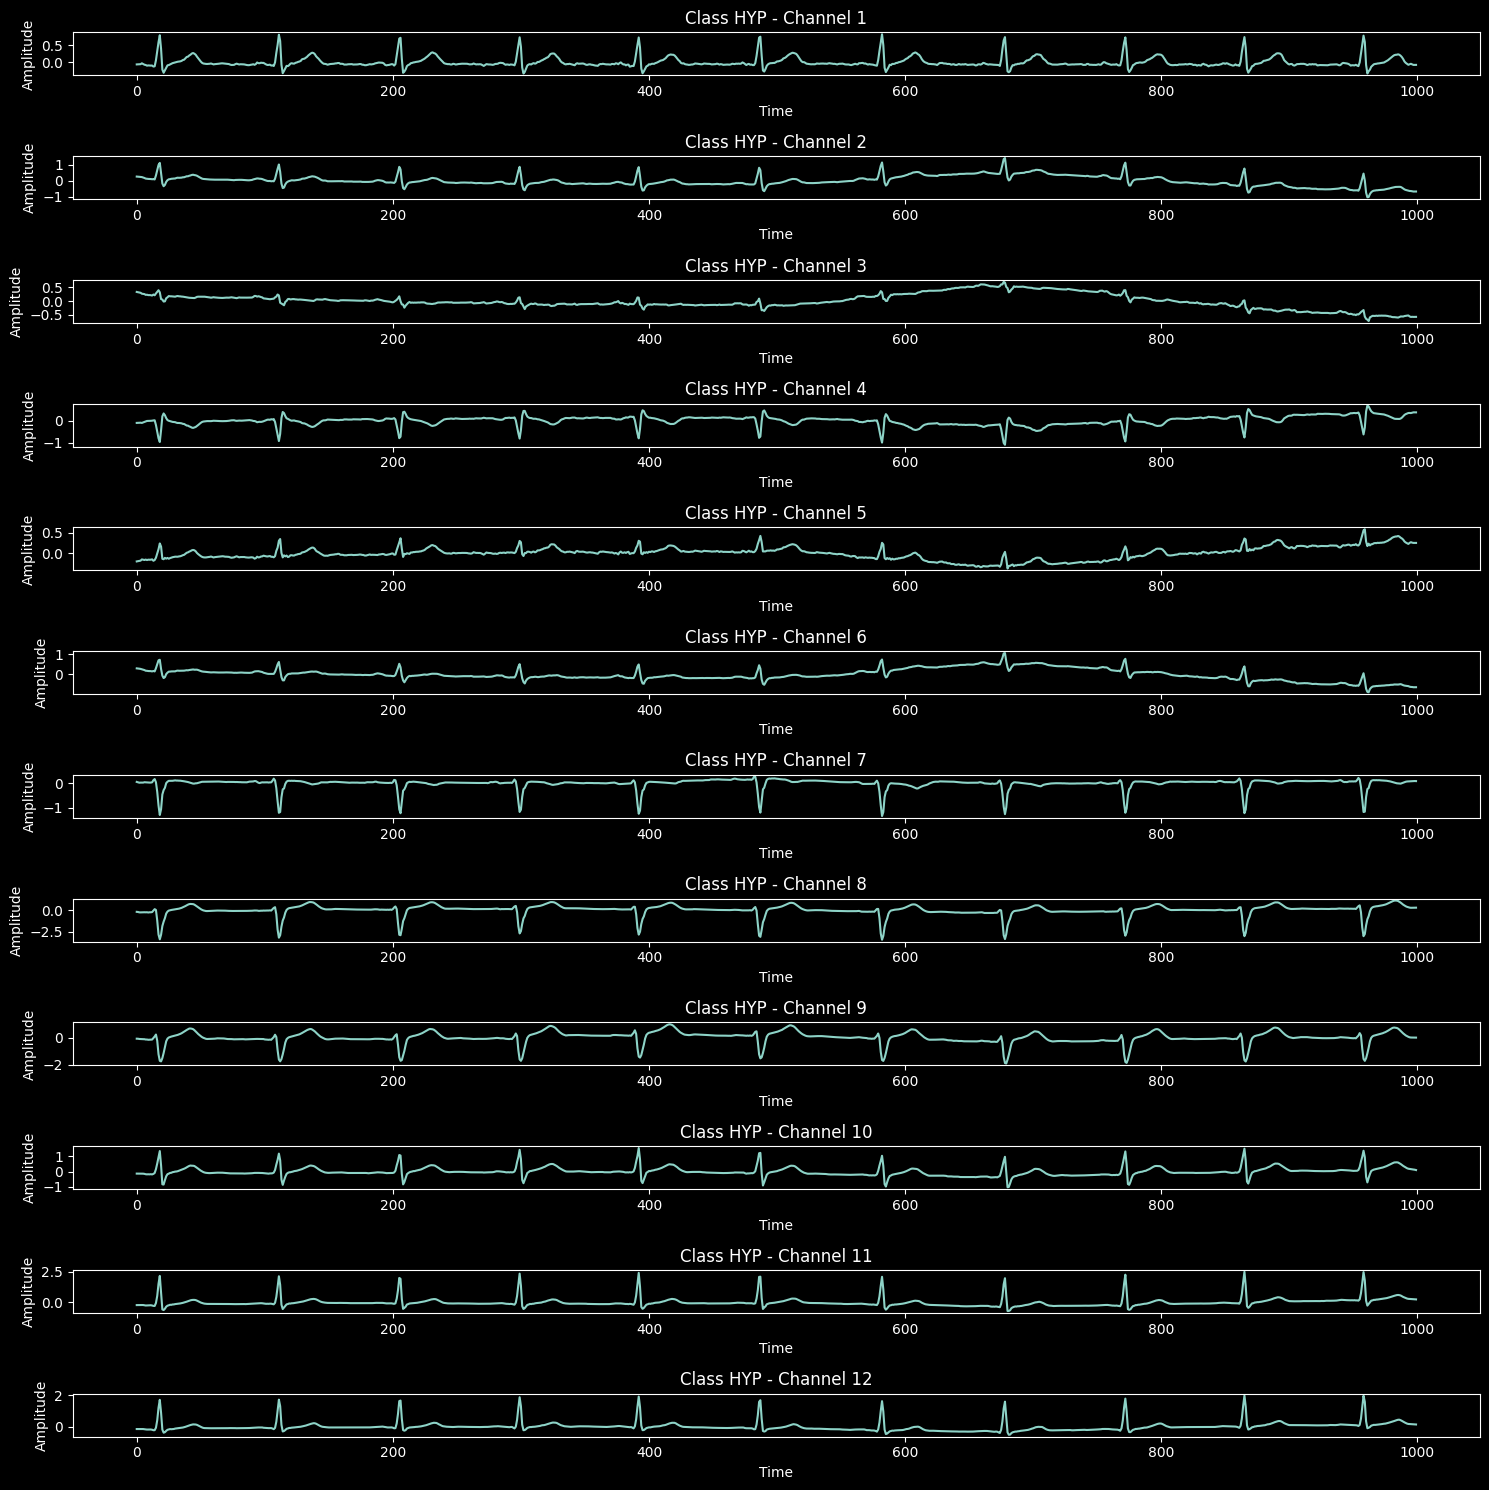

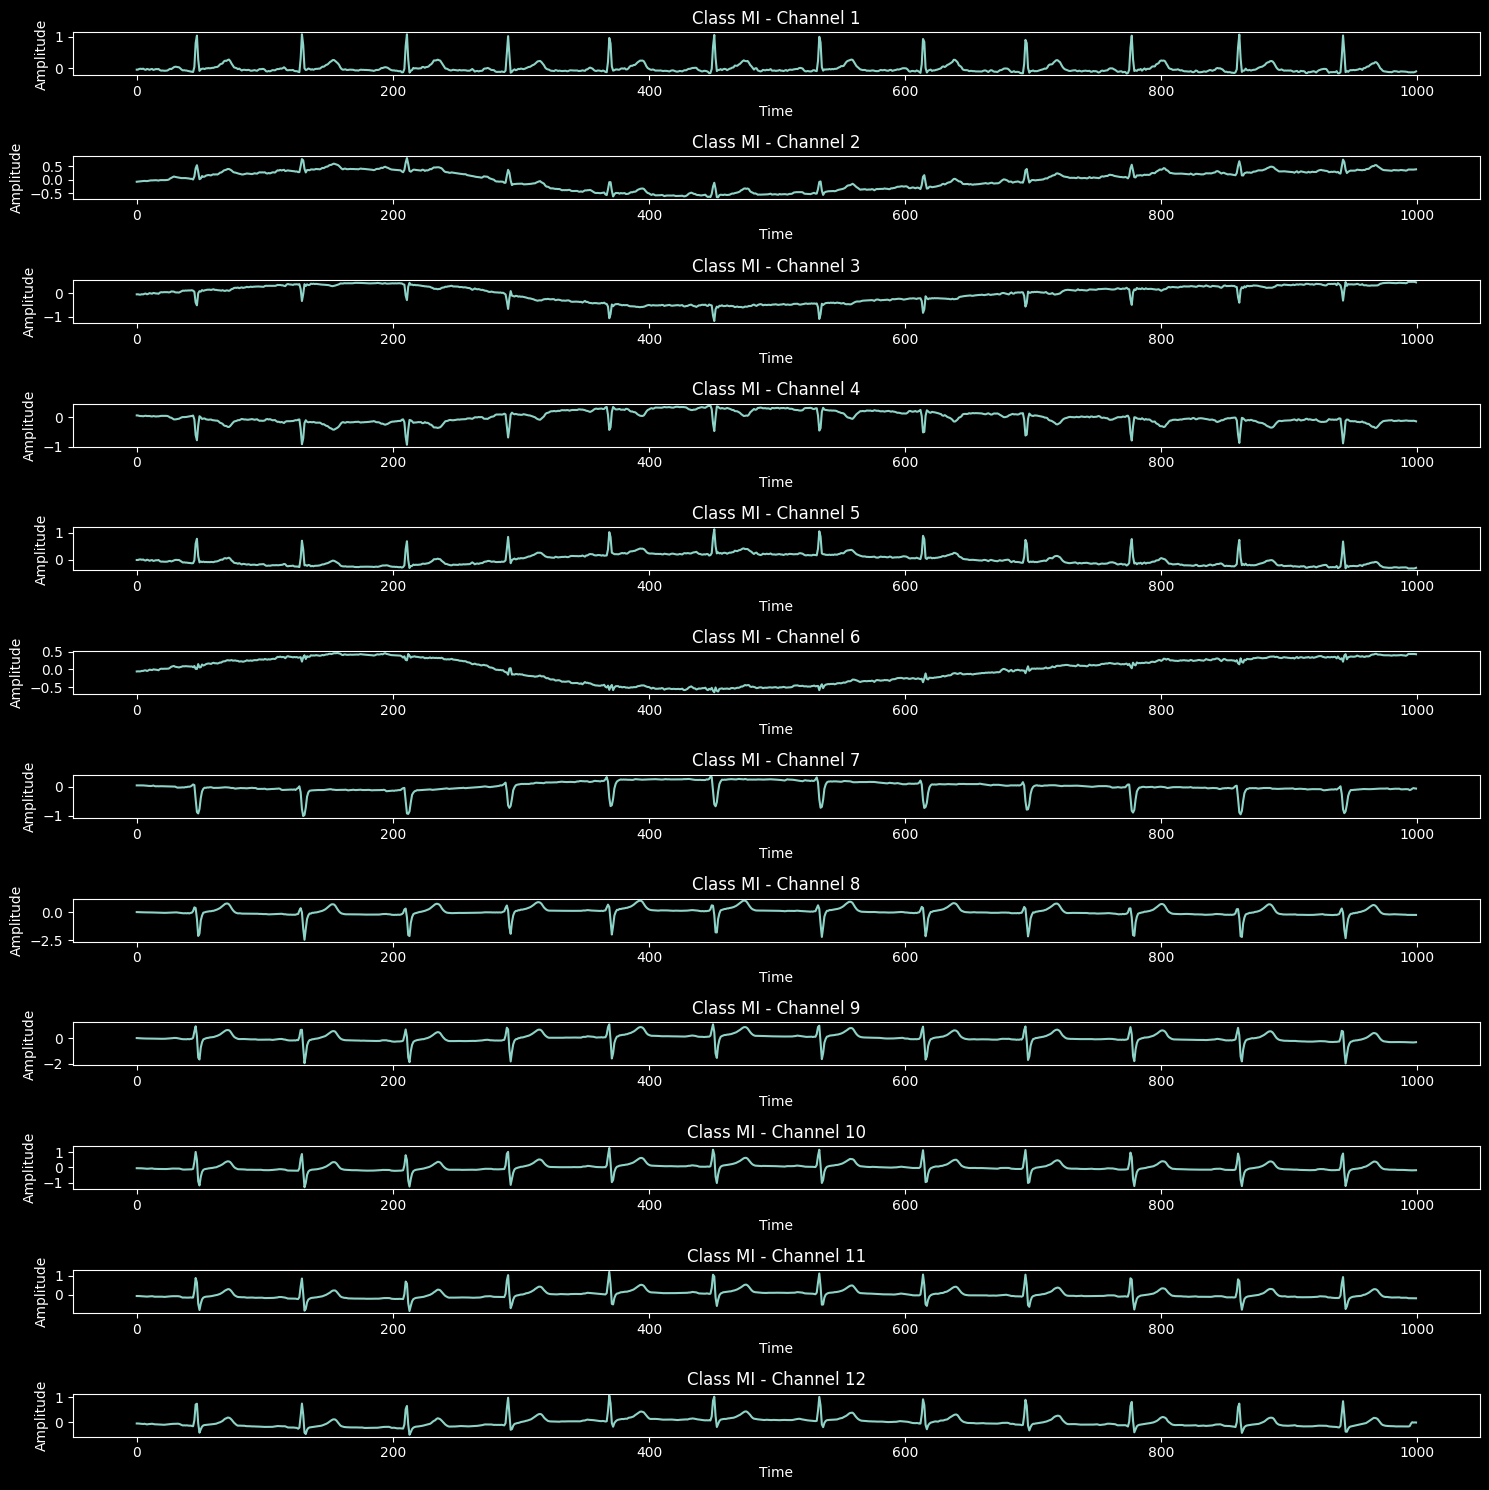

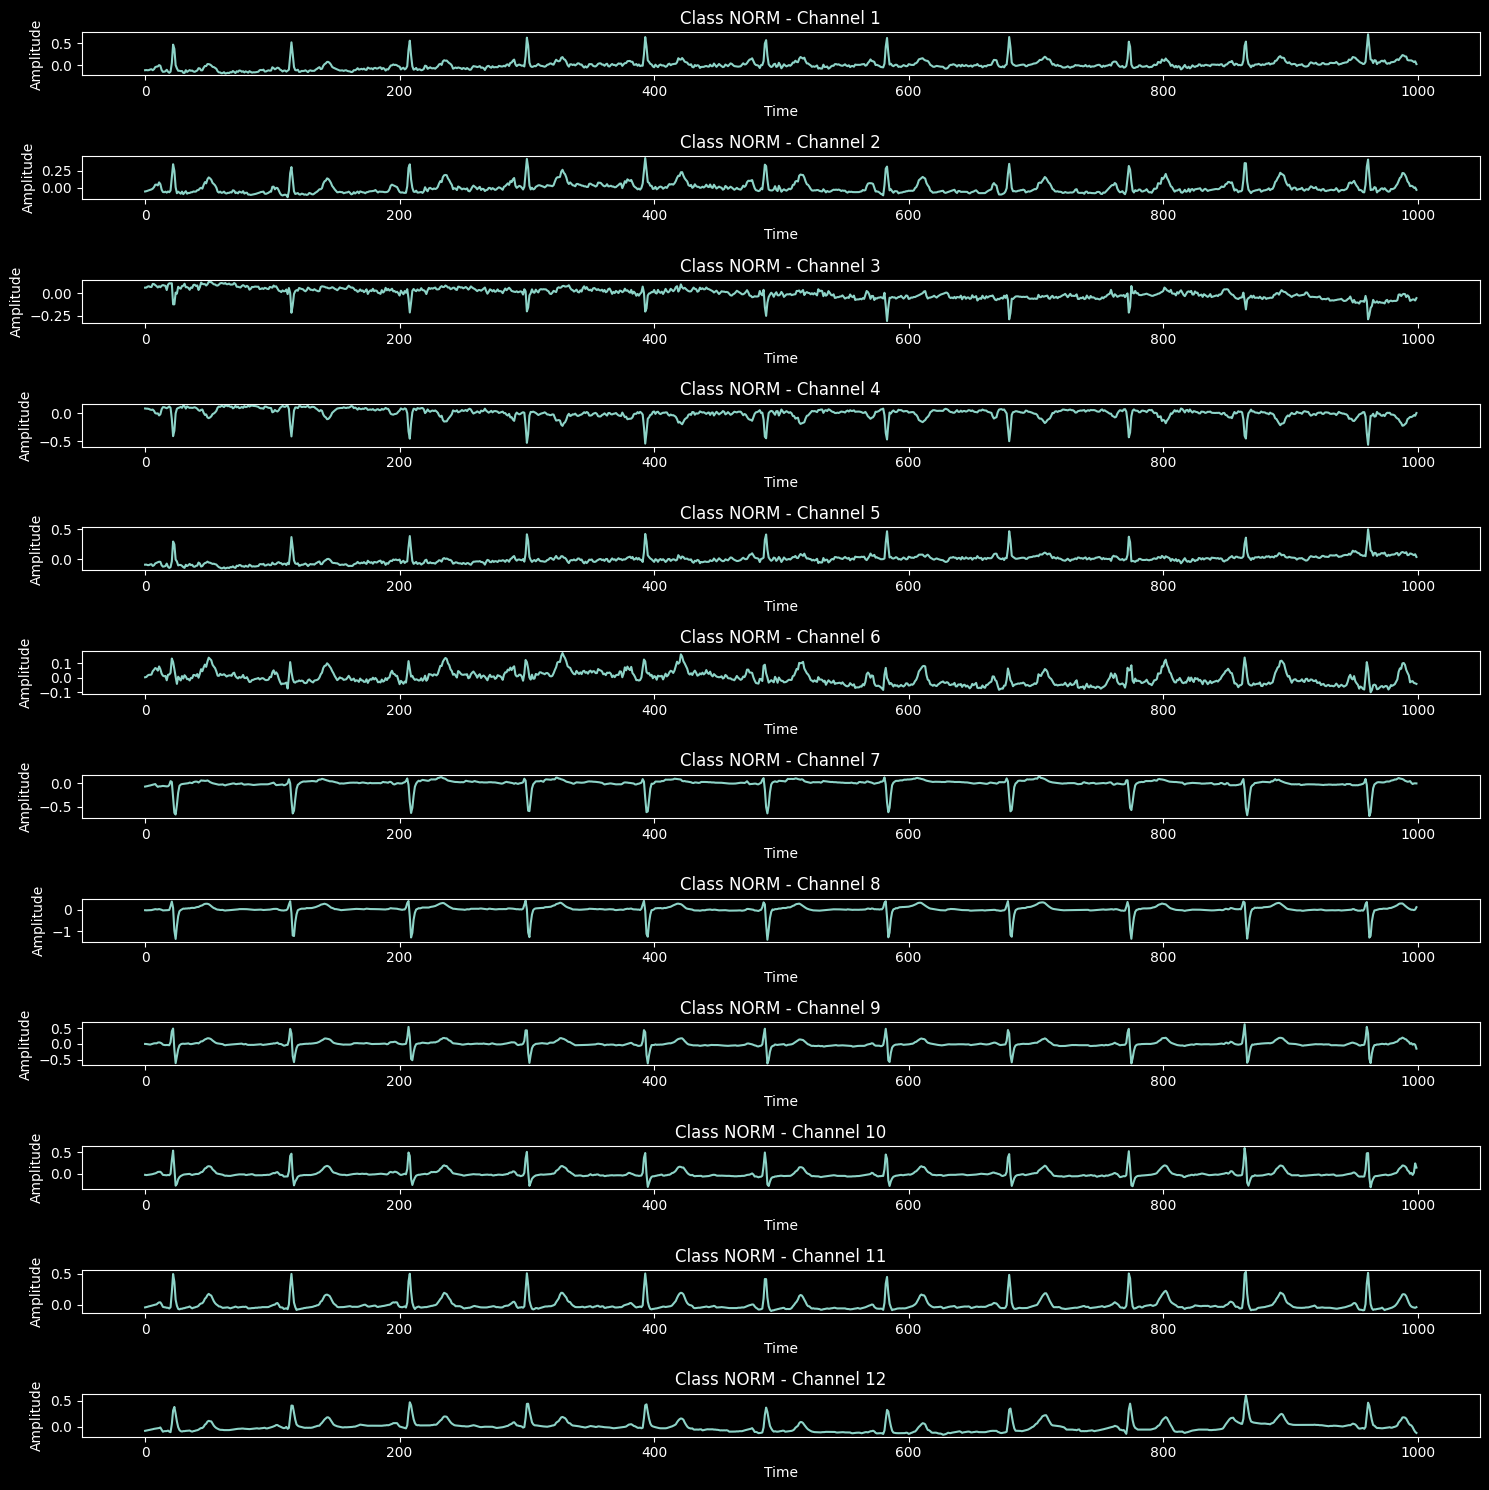

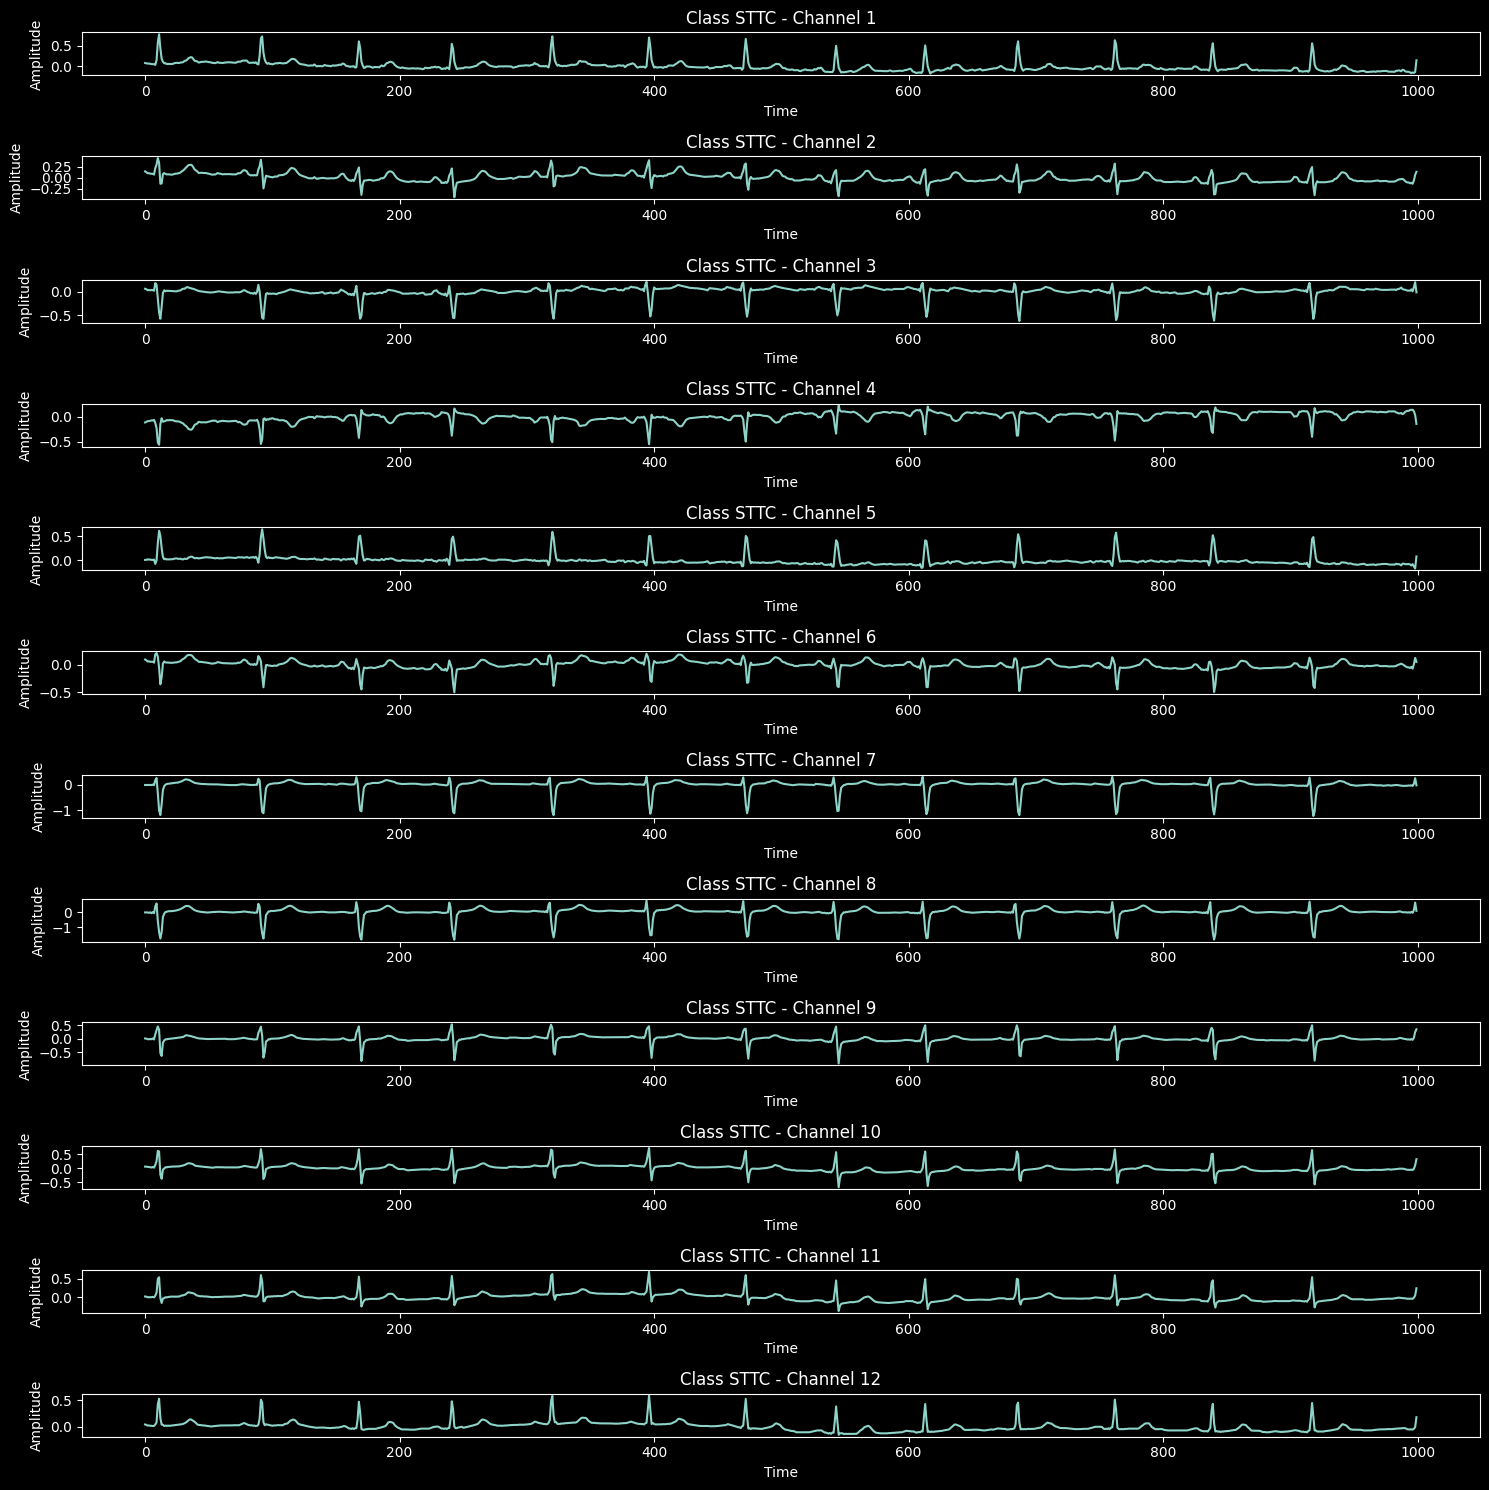

In [34]:
unique_classes = y_train_encoded.columns  # Getting the unique class labels
num_channels = X_train.shape[2]

# Loop through each class and plot the 12 channels for a representative sample
for class_label in unique_classes:
    # Get indices of the samples belonging to the current class
    class_indices = y_train_encoded.index[y_train_encoded[class_label] == 1]
    
    if len(class_indices) == 0:
        continue  # Skip classes without samples
    
    # Pick the first sample from the class for visualization
    sample_index = class_indices[0]
    
    # Plot the 12 channels for this class's sample
    plt.figure(figsize=(15, 15))
    for channel in range(num_channels):
        plt.subplot(num_channels, 1, channel + 1)
        plt.plot(X_train[sample_index, :, channel])
        plt.title(f"Class {class_label} - Channel {channel + 1}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

### Check variance in dataset across classes

Interpretation of the Graphs:
Mean Signal (solid line): Shows the overall "average" ECG pattern for each channel within the class. This is useful for identifying general trends in the signal, such as the shape of the P wave, QRS complex, and T wave, which could vary based on the class (e.g., normal vs. arrhythmia).
Variance (shaded region): The area around the mean that indicates the variability of the ECG signals within that class and channel. A wider shaded area indicates greater variability (higher variance), while a narrower shaded area indicates more consistency (lower variance).

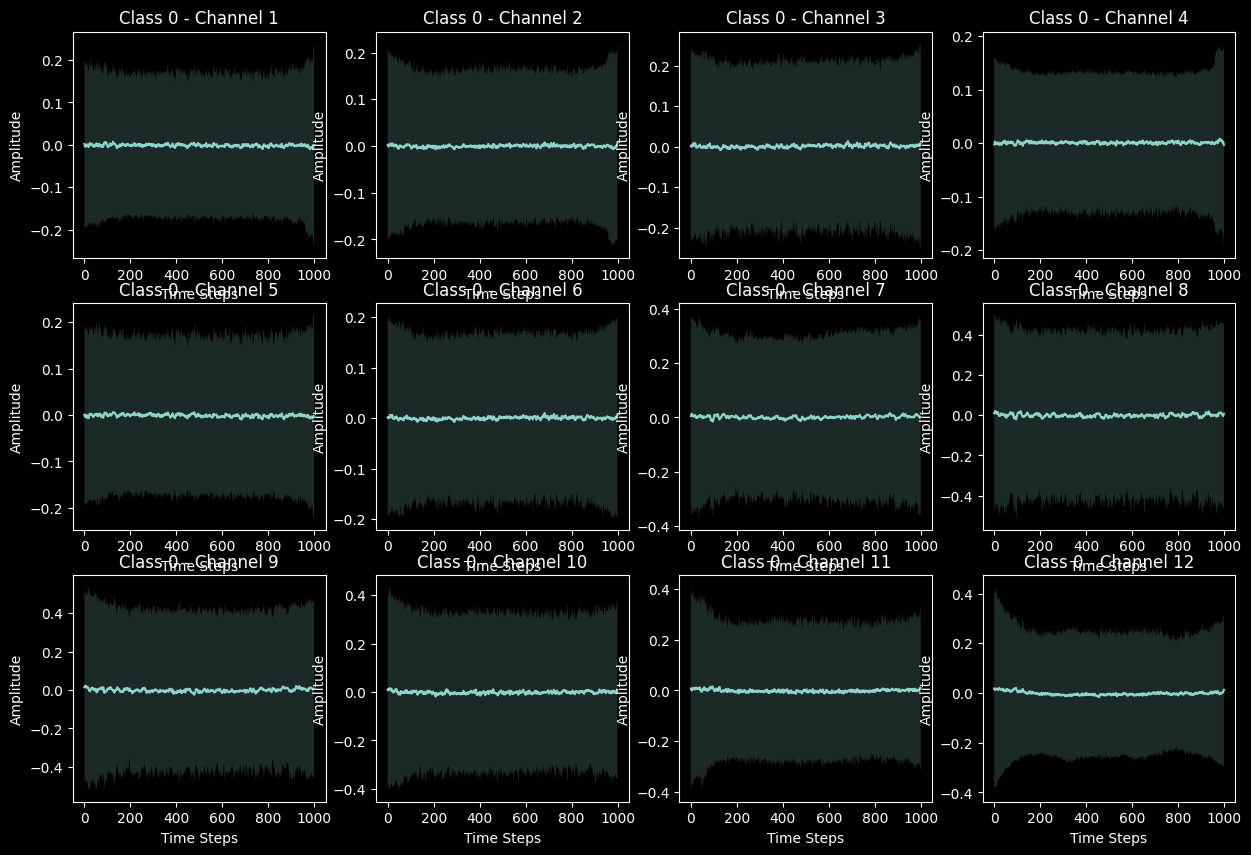

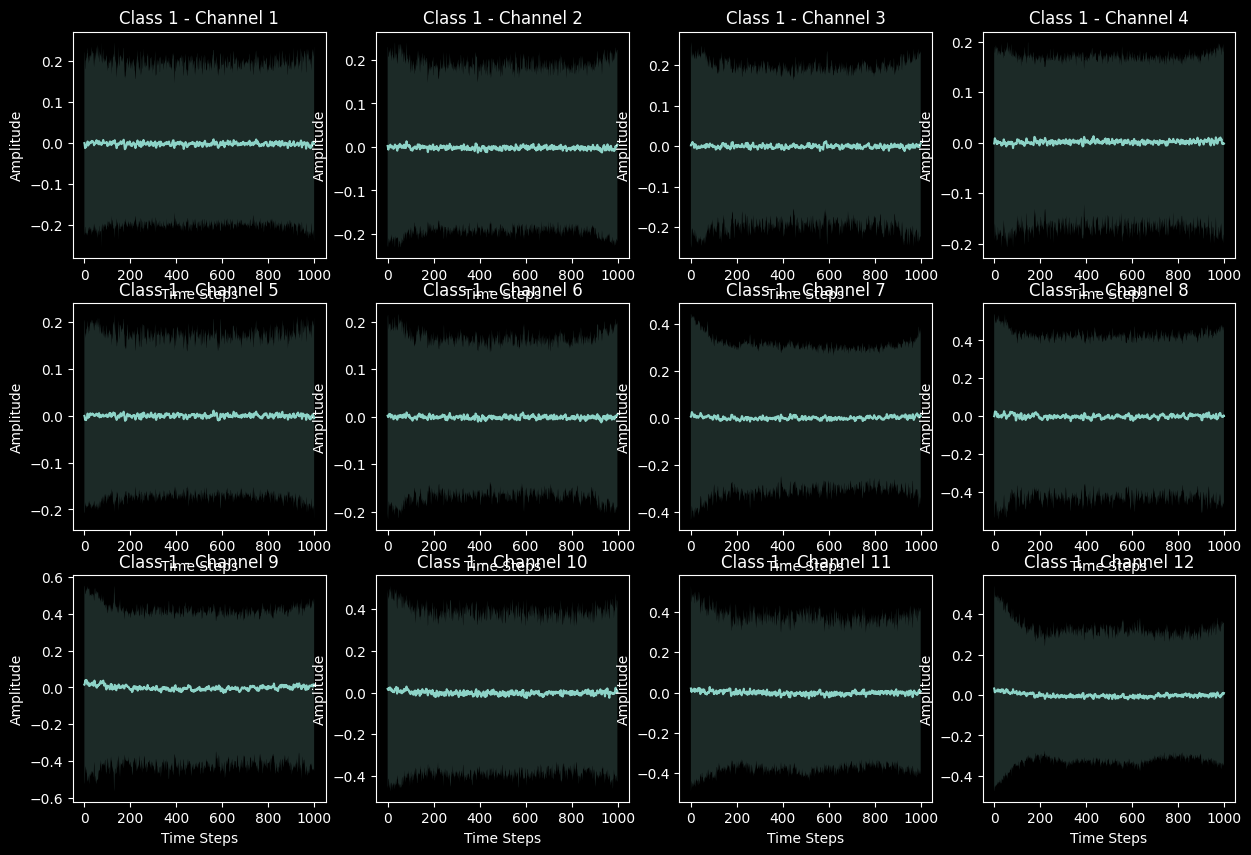

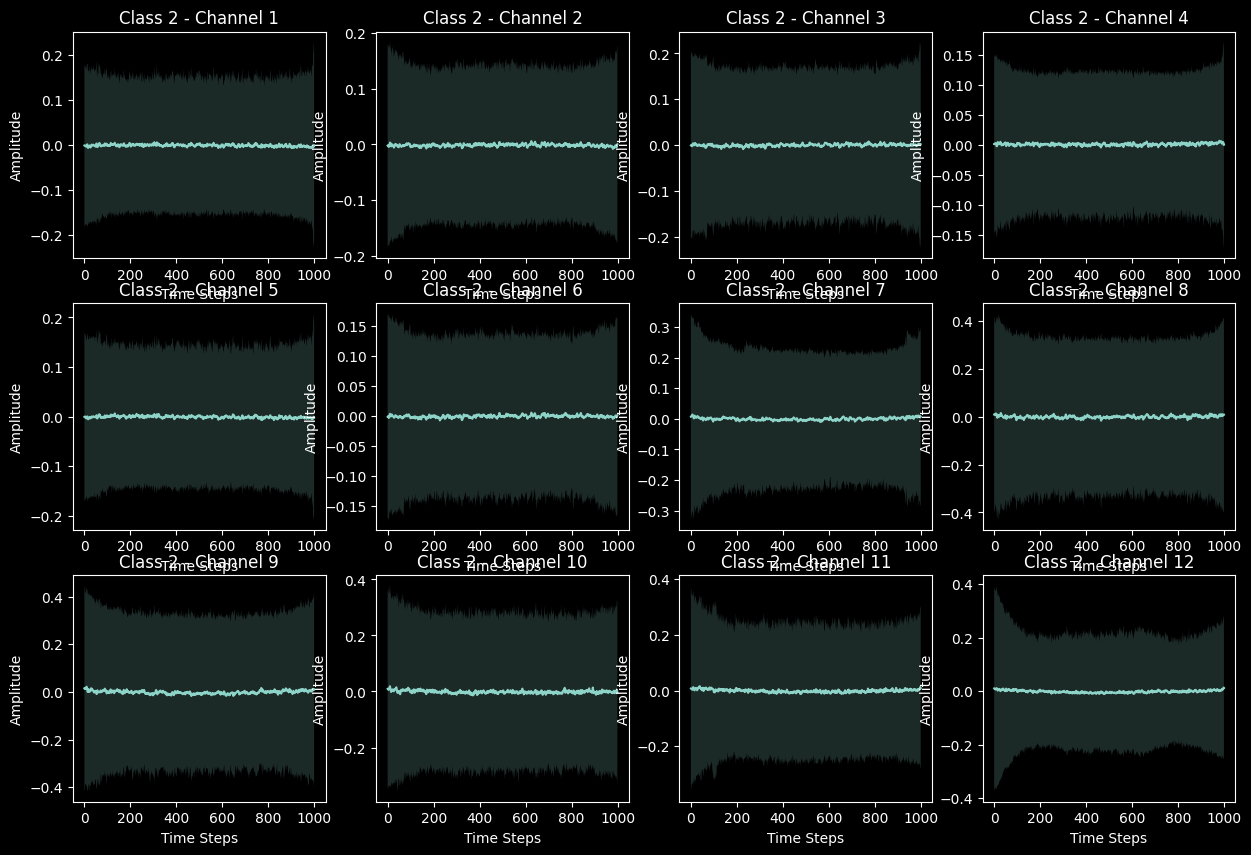

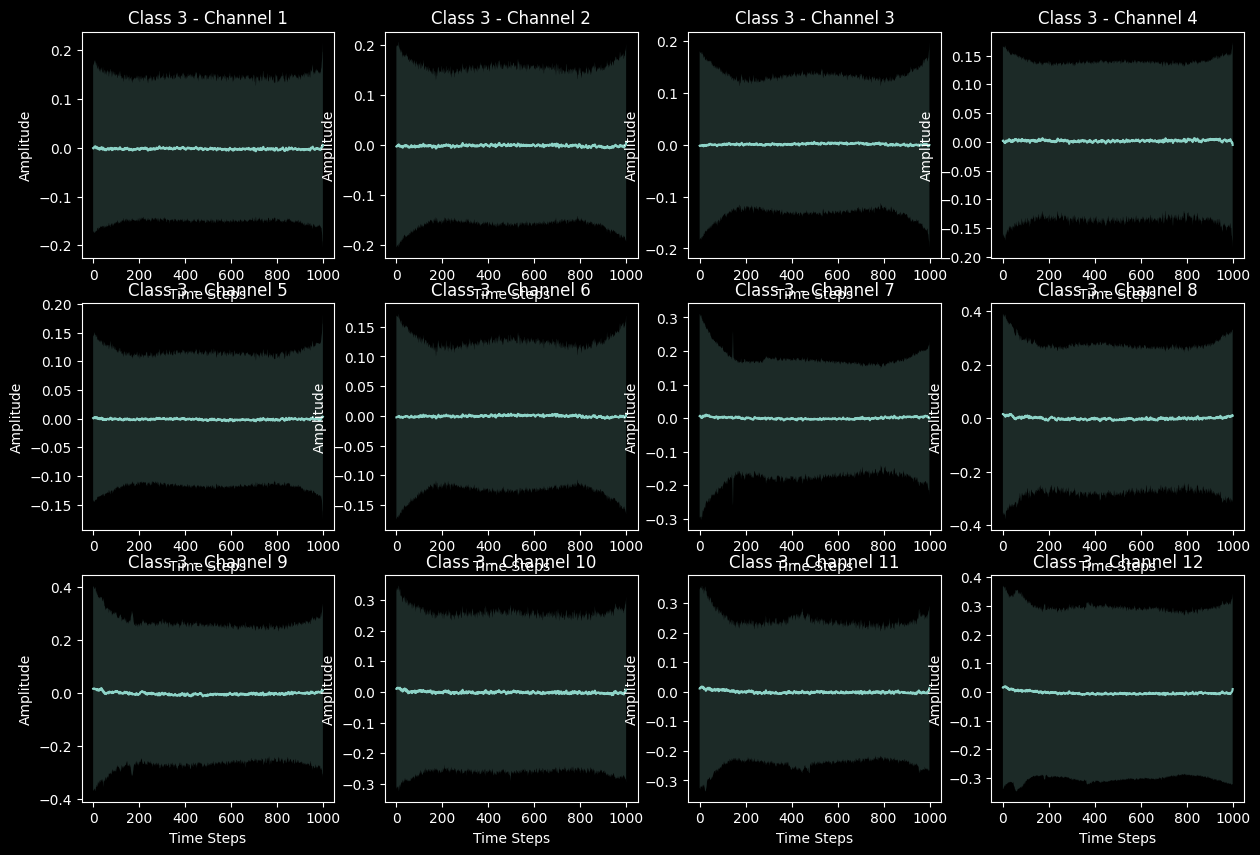

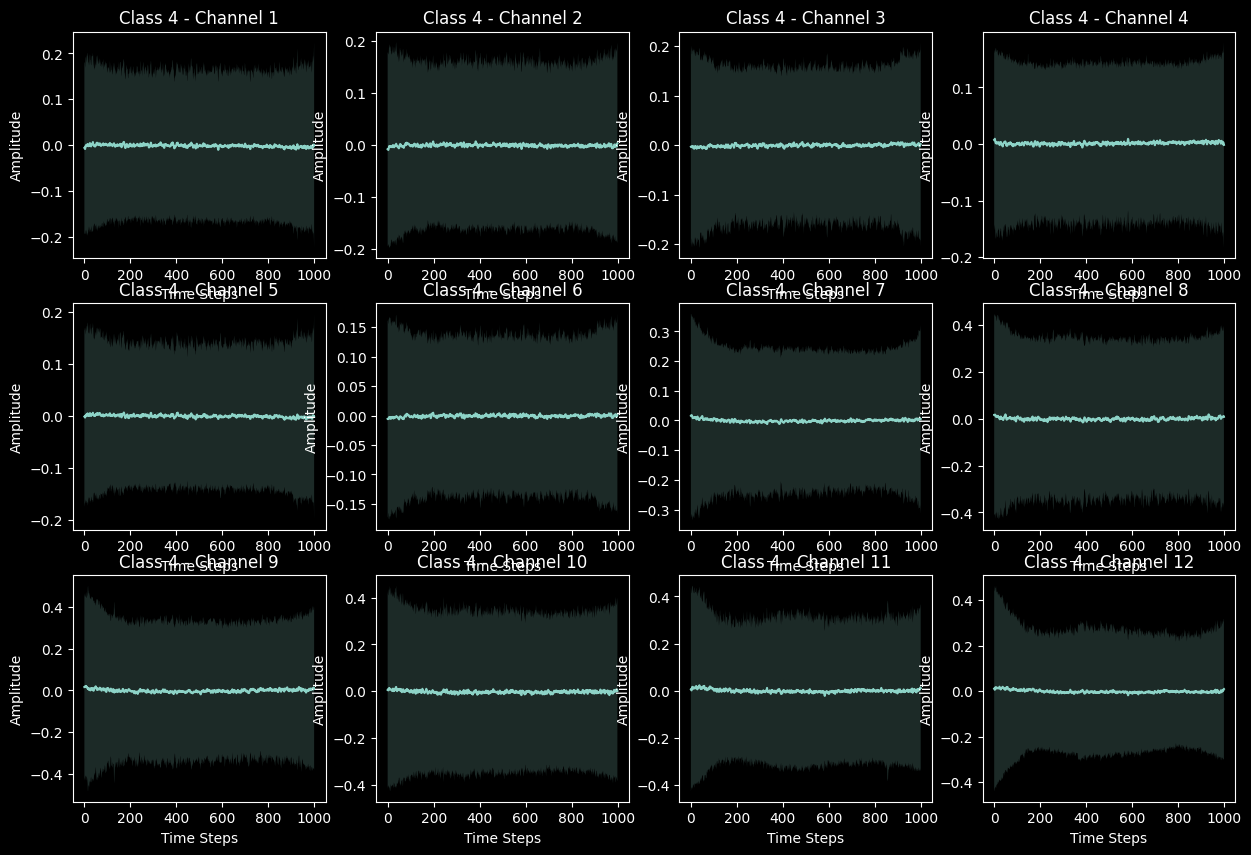

In [48]:
num_classes = y_train_encoded.shape[1]  # Number of classes
num_channels = X_train.shape[2]  # Number of ECG channels 
time_steps = X_train.shape[1]  # Time steps in each ECG recording

# Initialize arrays to store mean and variance per class and per channel
class_means = np.zeros((num_classes, num_channels, time_steps))
class_vars = np.zeros((num_classes, num_channels, time_steps))

# Compute mean and variance for each class across all ECG channels
for class_label in range(num_classes):
    # Get the indices for the current class
    class_indices = np.where(y_train_encoded.iloc[:, class_label] == 1)[0]
    class_data = X_train[class_indices]  # ECG data for current class
    
    # Compute mean and variance for each channel
    class_means[class_label] = np.mean(class_data, axis=0).T
    class_vars[class_label] = np.var(class_data, axis=0).T

# Plot the results for each class (mean and variance for each channel)
for class_label in range(num_classes):
    plt.figure(figsize=(15, 10))
    
    # Plot mean ECG signals across all channels for the current class
    for channel in range(num_channels):
        plt.subplot(3, 4, channel + 1)
        plt.plot(class_means[class_label][channel], label=f'Channel {channel + 1}')
        plt.fill_between(range(time_steps), 
                         class_means[class_label][channel] - np.sqrt(class_vars[class_label][channel]),
                         class_means[class_label][channel] + np.sqrt(class_vars[class_label][channel]),
                         alpha=0.2)
        plt.title(f'Class {class_label} - Channel {channel + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Amplitude')


Results : 

- A wide shaded region means the variance is too high.
- The mean of each channel doesn't highlight specific features of the signals. What this means is there is very less difference between features of each channel.


### Objective metrices 

Visually observing them might not be a smart way to approach this problem. To gain more insight into the data and convert it into meaningful metrics and parameters, we can use statistical and feature extraction techniques.

In [49]:
from scipy.stats import skew, kurtosis

# Initialize dictionaries to store statistics
class_stats = {}

# Compute statistics for each class
for class_label in range(num_classes):
    class_indices = np.where(y_train_encoded.iloc[:, class_label] == 1)[0]
    class_data = X_train[class_indices]  # ECG data for current class
    
    # Compute statistics for each channel
    class_stats[class_label] = {
        'mean': np.mean(class_data, axis=0),
        'std': np.std(class_data, axis=0),
        'min': np.min(class_data, axis=0),
        'max': np.max(class_data, axis=0),
        'skew': skew(class_data, axis=0),
        'kurtosis': kurtosis(class_data, axis=0),
    }

# Example of accessing the statistics for class 0
print(class_stats[0]['mean'])


[[ 0.00223353  0.00266901  0.0004473  ...  0.01019945  0.00766901
   0.01837369]
 [ 0.00023489  0.00259564  0.00237665 ...  0.0113169   0.0075134
   0.01825897]
 [-0.00199387  0.00159564  0.00360677 ...  0.01120809  0.00517038
   0.01599955]
 ...
 [-0.00224852 -0.0001413   0.00210018 ...  0.00804748  0.00753385
   0.00649182]
 [ 0.00013766  0.00478941  0.0046254  ...  0.0083144   0.0105209
   0.01018287]
 [-0.00013426  0.00699137  0.00708996 ...  0.0073771   0.00956338
   0.01308496]]


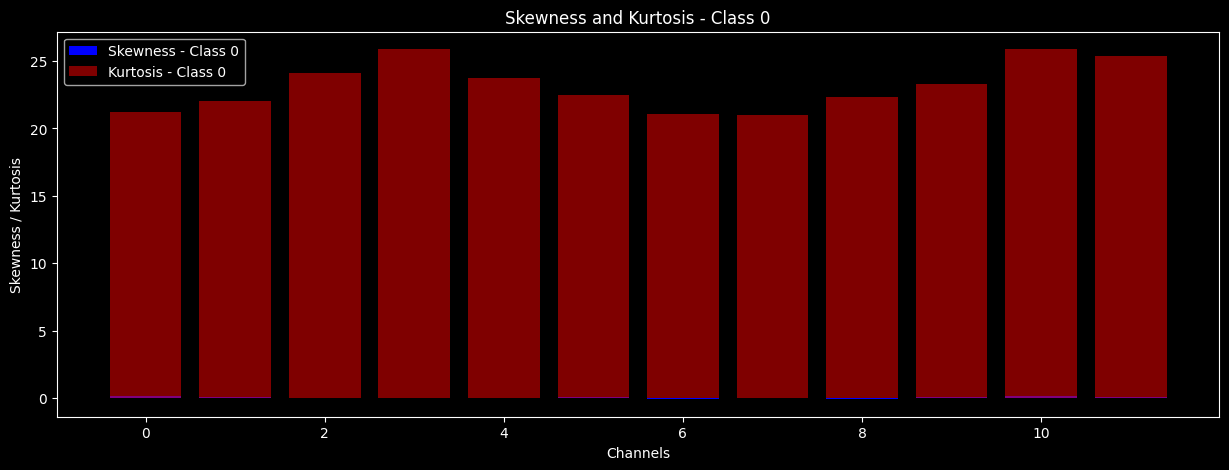

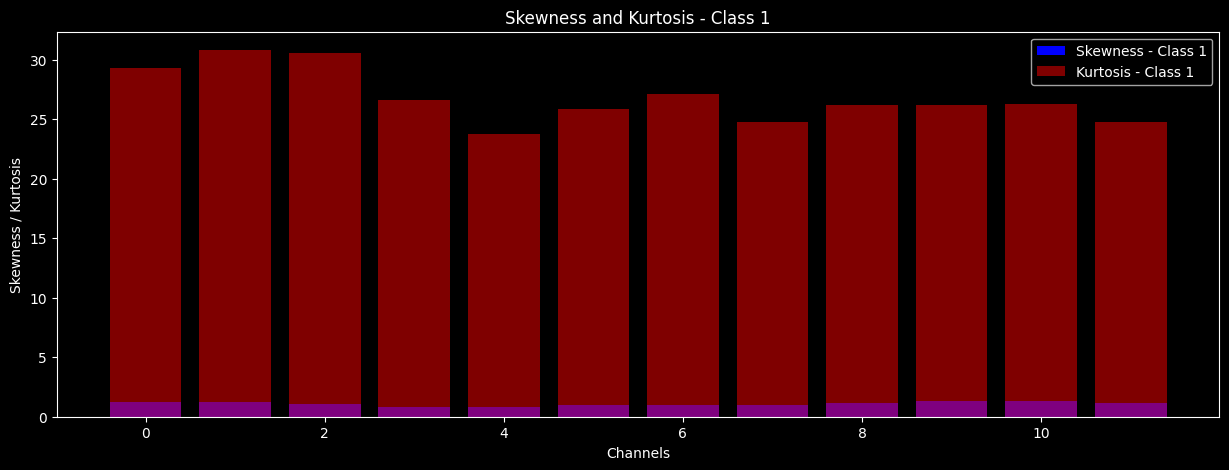

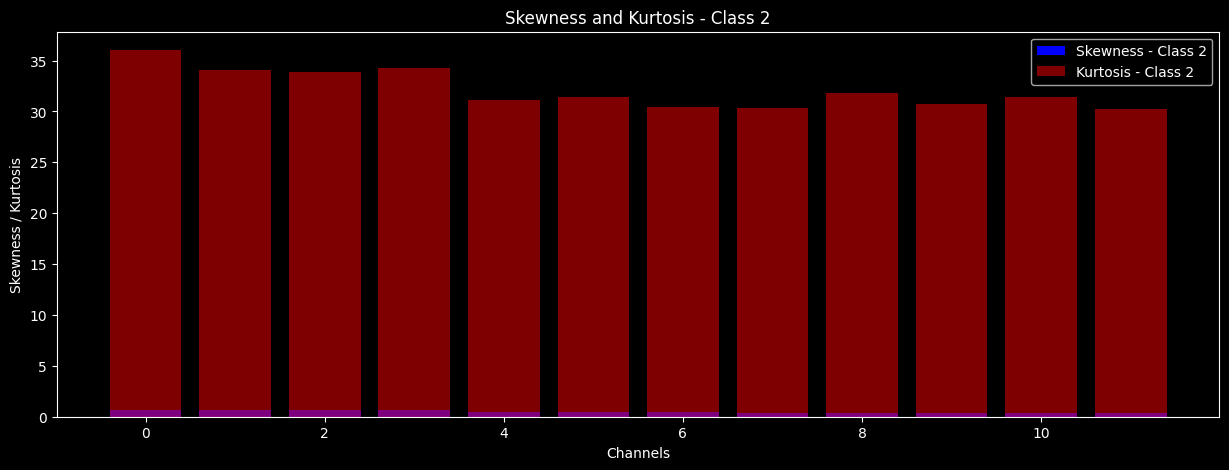

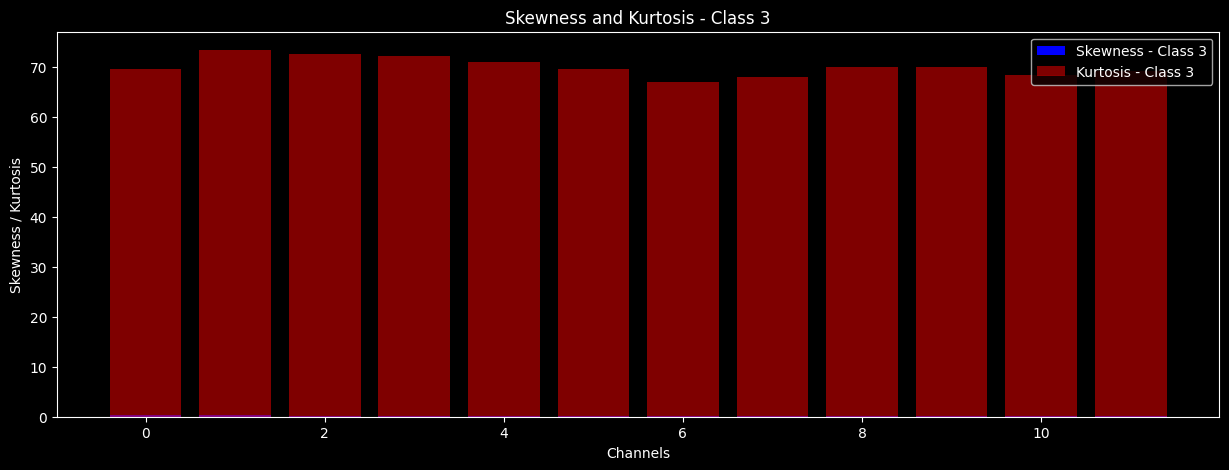

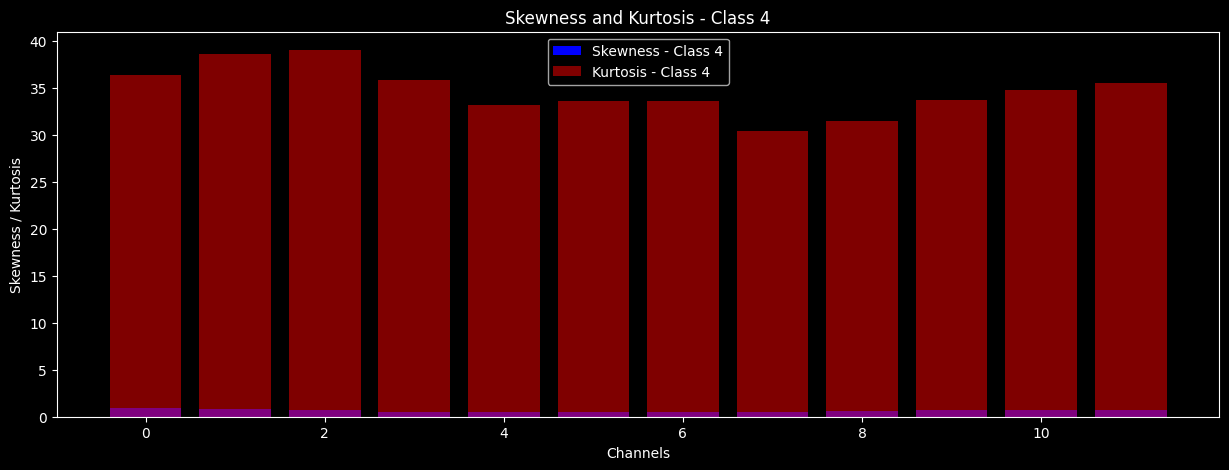

In [54]:
for class_label in range(num_classes):
    plt.figure(figsize=(15, 5))
    plt.bar(range(num_channels), 
            [class_stats[class_label]['skew'][i].mean() for i in range(num_channels)], 
            color='b', label=f'Skewness - Class {class_label}')
    plt.bar(range(num_channels), 
            [class_stats[class_label]['kurtosis'][i].mean() for i in range(num_channels)], 
            color='r', alpha=0.5, label=f'Kurtosis - Class {class_label}')
    plt.title(f'Skewness and Kurtosis - Class {class_label}')
    plt.xlabel('Channels')
    plt.ylabel('Skewness / Kurtosis')
    plt.legend()
    plt.show()


Frequency domain analysis

In [51]:
from scipy.fft import fft

# Compute FFT for each channel and class
for class_label in range(num_classes):
    class_indices = np.where(y_train_encoded.iloc[:, class_label] == 1)[0]
    class_data = X_train[class_indices]  # ECG data for current class
    
    # Apply FFT
    fft_data = fft(class_data, axis=1)  # Fourier transform along the time axis
    # Now you can analyze the frequency components (e.g., dominant frequency)


signal over time

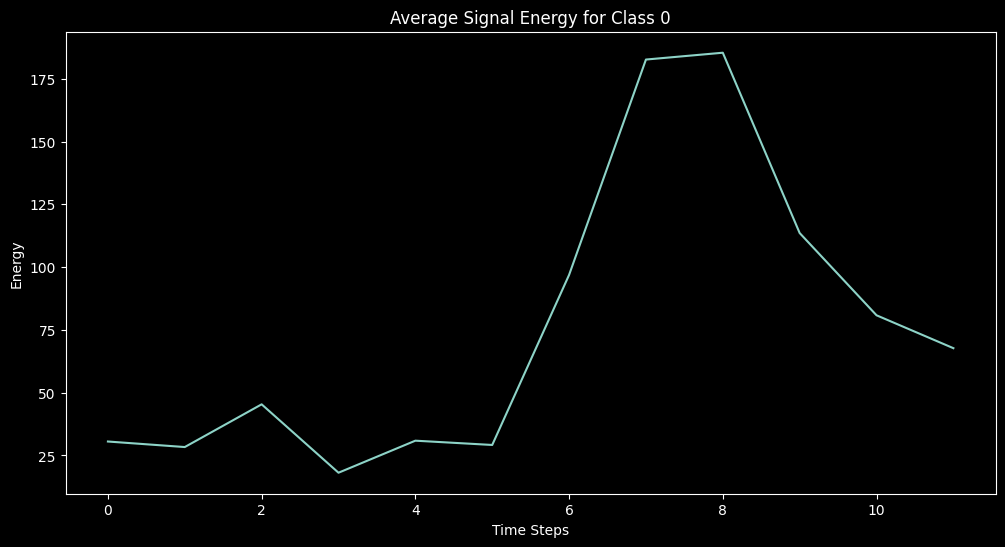

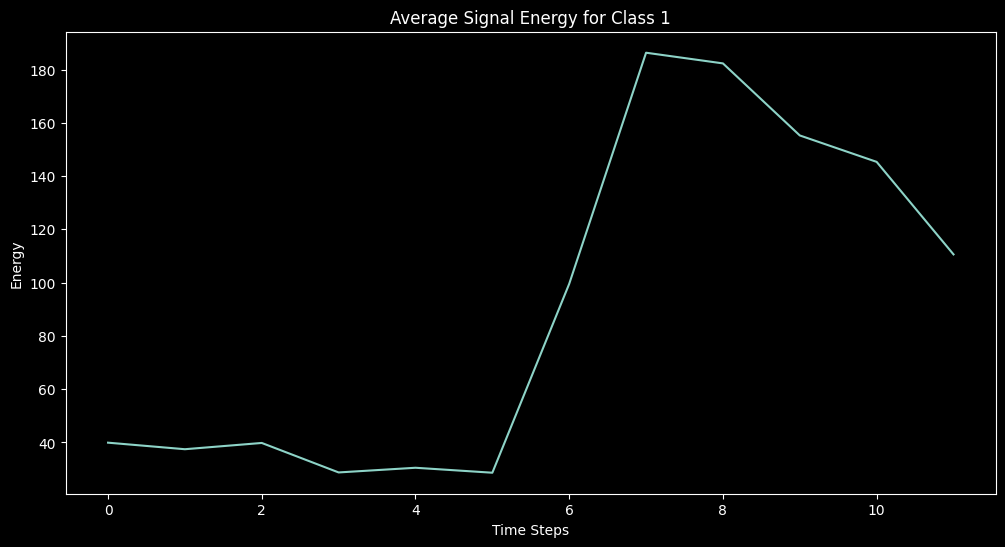

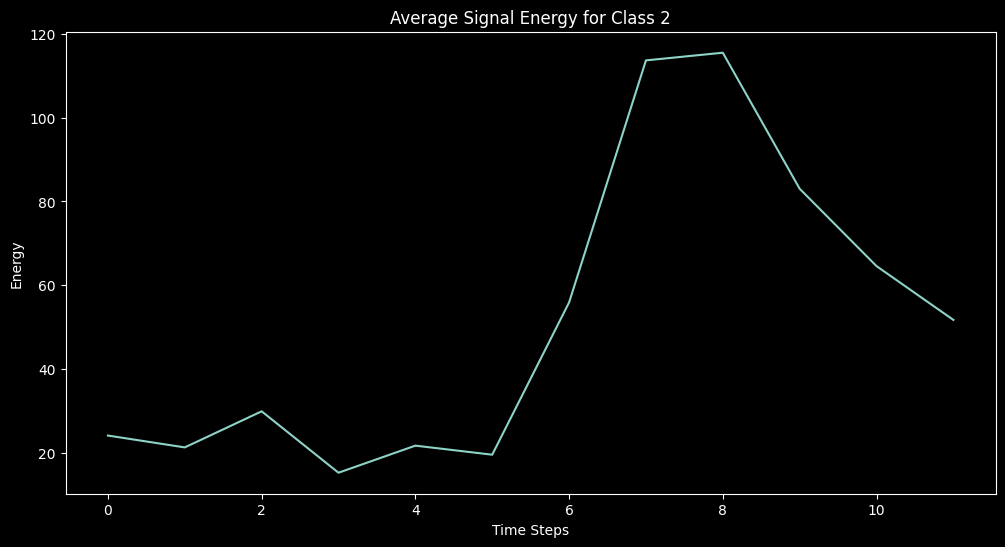

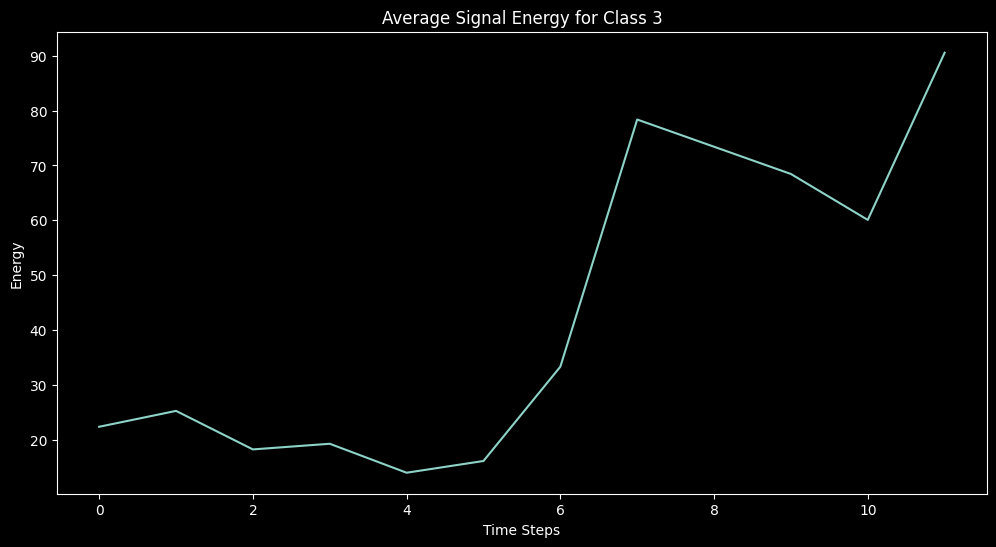

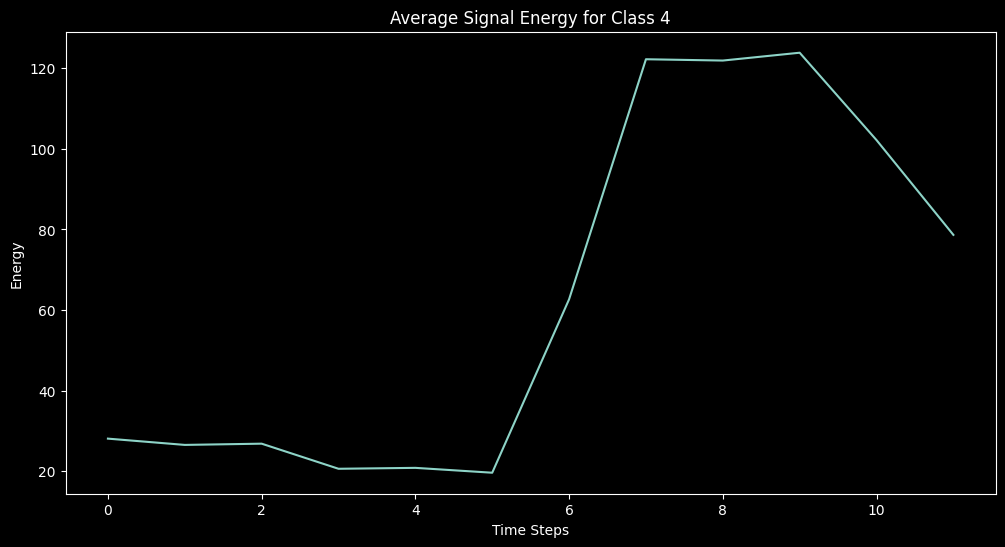

In [55]:
# Compute signal energy for each channel
energy = np.sum(X_train**2, axis=1)  # Energy per sample (sum of squares)

# Plot energy for a sample in each class
for class_label in range(num_classes):
    plt.figure(figsize=(12, 6))
    class_indices = np.where(y_train_encoded.iloc[:, class_label] == 1)[0]
    class_data = X_train[class_indices]
    
    # Plot energy for the first sample in this class
    plt.plot(np.mean(energy[class_indices], axis=0))
    plt.title(f'Average Signal Energy for Class {class_label}')
    plt.xlabel('Time Steps')
    plt.ylabel('Energy')
    plt.show()


Correlation analysis between classes 

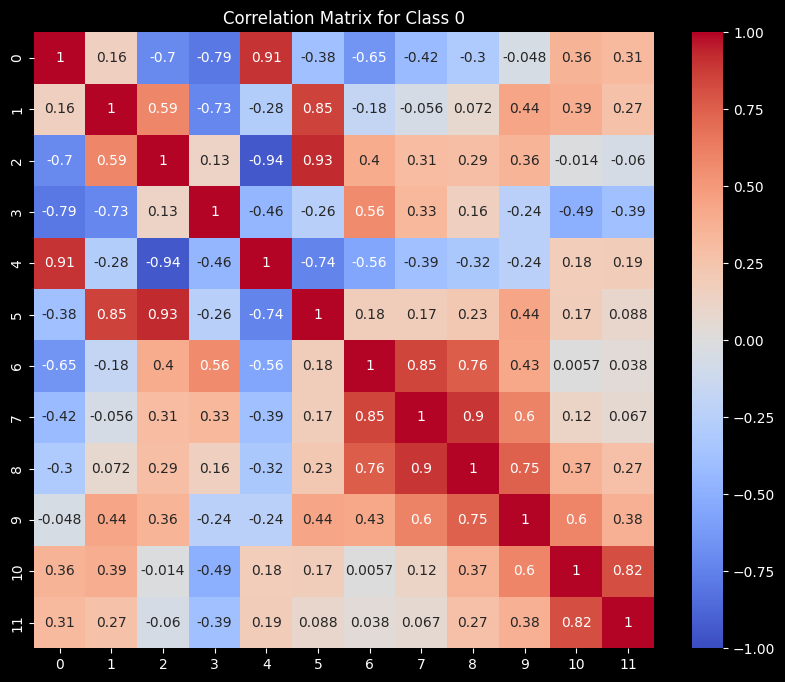

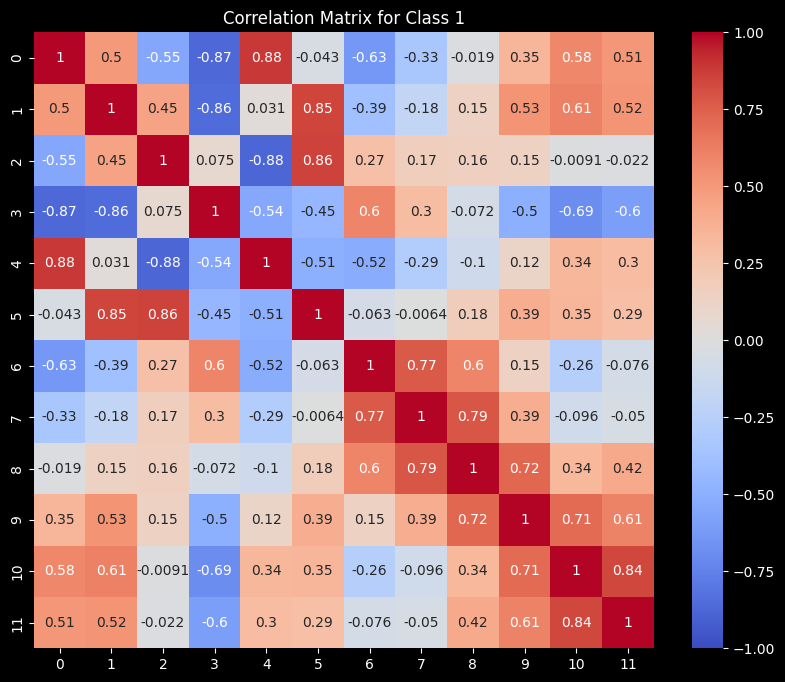

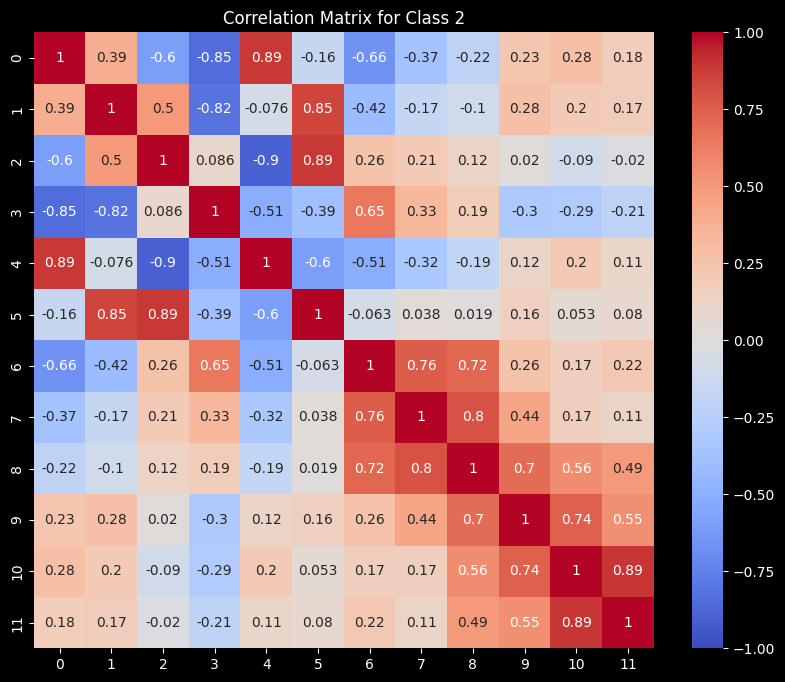

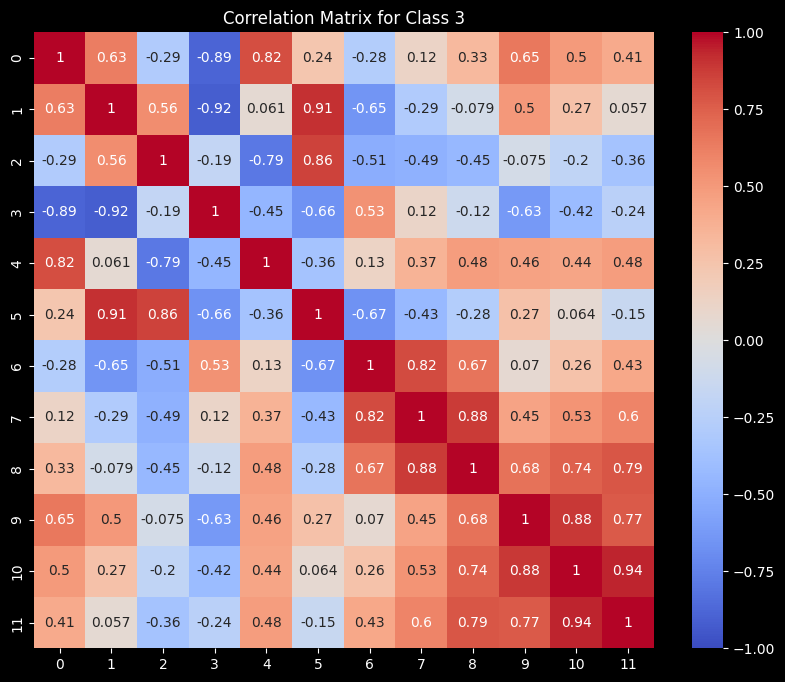

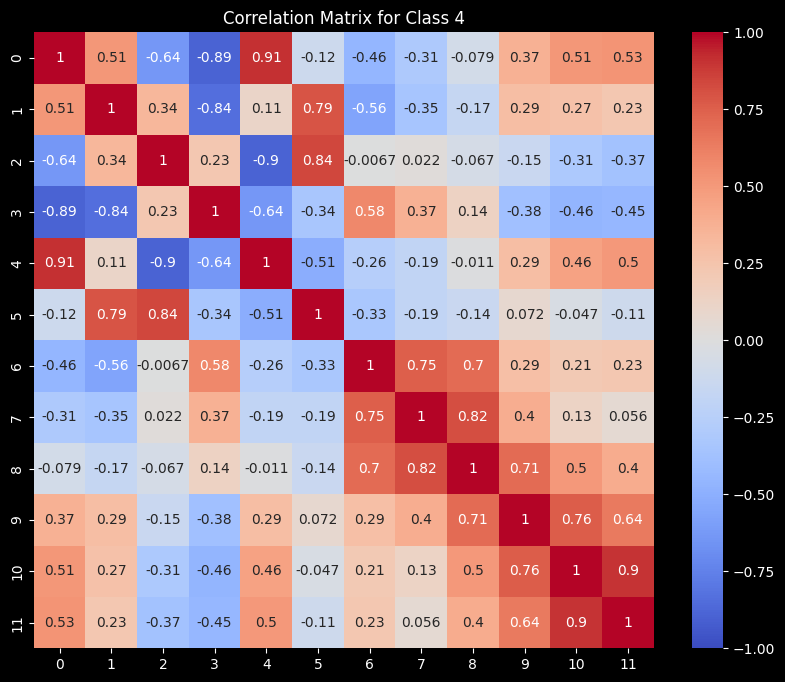

In [59]:
import seaborn as sns

for class_label in range(num_classes):
    class_indices = np.where(y_train_encoded.iloc[:, class_label] == 1)[0]
    class_data = X_train[class_indices]  # ECG data for current class
    
    # Reshape to 2D: (channels, time_steps)
    avg_class_data = np.mean(class_data, axis=0)
    
    # Compute correlation matrix between channels
    correlation_matrix = np.corrcoef(avg_class_data.T)
    
    # Plot correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for Class {class_label}')
    plt.show()


Feature analysis

In [53]:
features = []

for class_label in range(num_classes):
    class_indices = np.where(y_train_encoded.iloc[:, class_label] == 1)[0]
    class_data = X_train[class_indices]  # ECG data for current class
    
    # Aggregate features for each class
    feature_vector = []
    for channel in range(num_channels):
        mean_val = np.mean(class_data[:, :, channel])
        var_val = np.var(class_data[:, :, channel])
        skew_val = skew(class_data[:, :, channel], axis=0).mean()
        kurt_val = kurtosis(class_data[:, :, channel], axis=0).mean()
        feature_vector.append([mean_val, var_val, skew_val, kurt_val])
    
    features.append(feature_vector)



This will help you understand the distribution of each feature for different classes.

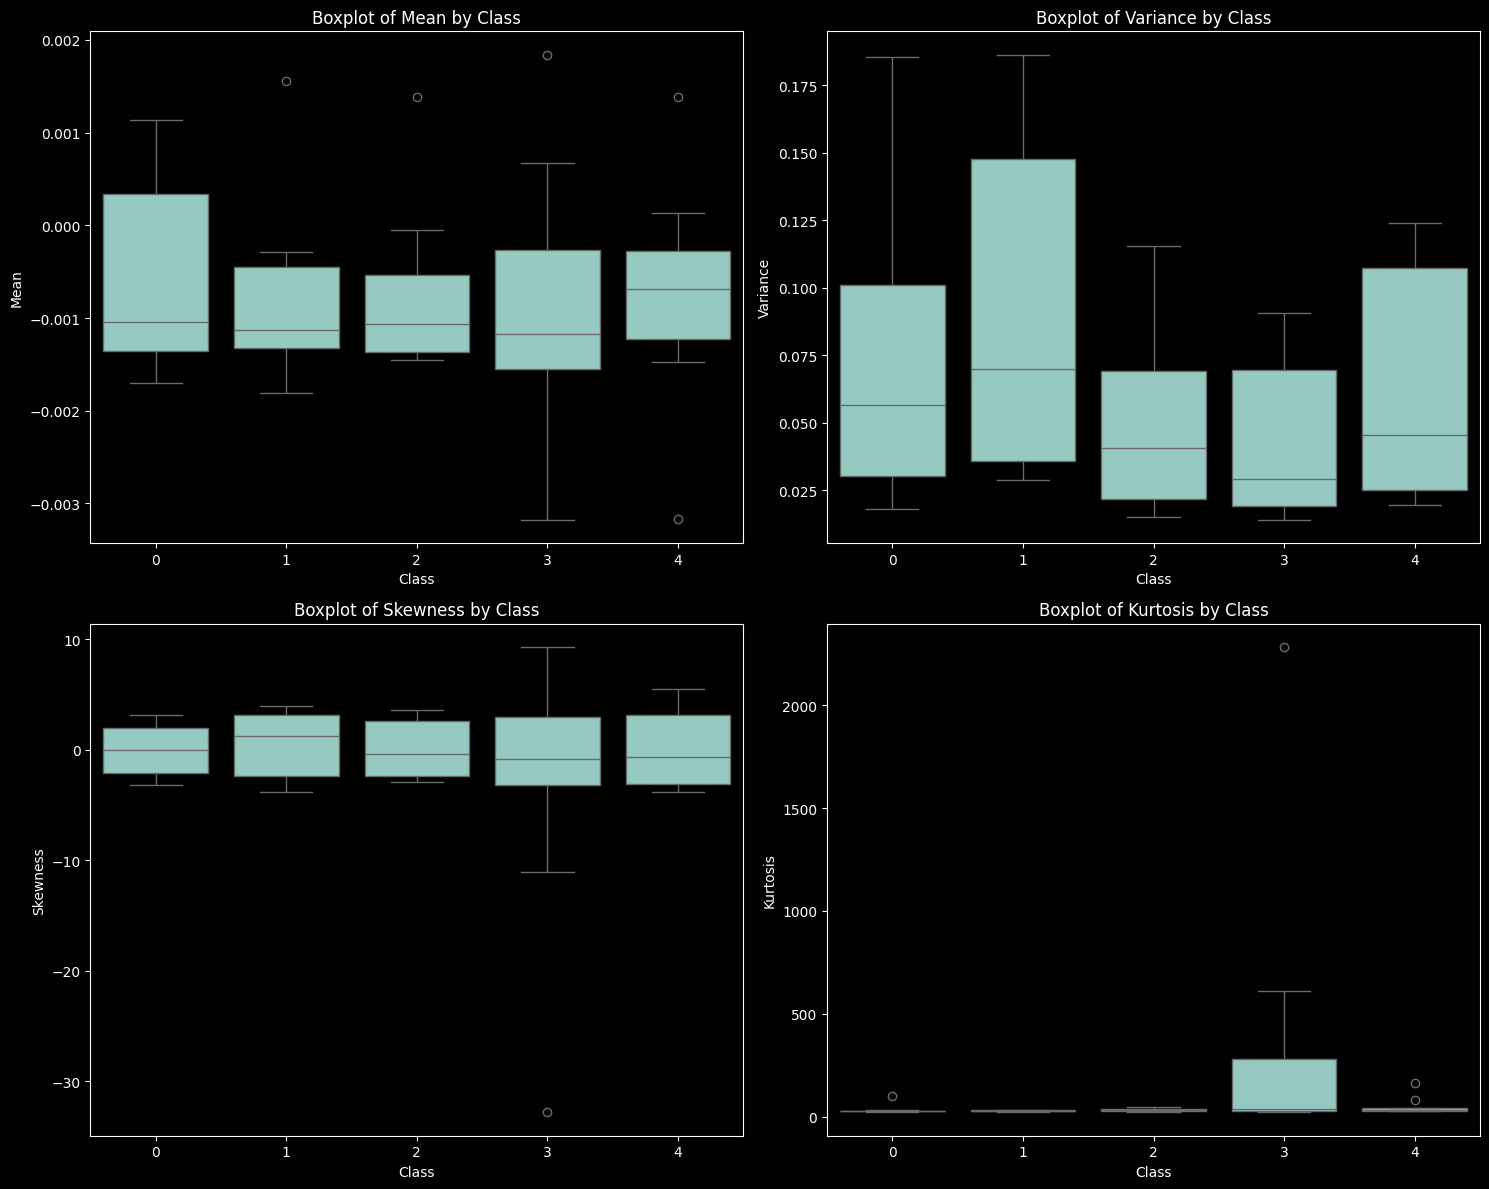

In [60]:
# Convert features list to a DataFrame
features_df = pd.DataFrame({
    'Class': np.repeat(range(num_classes), num_channels),
    'Channel': np.tile(range(num_channels), num_classes),
    'Mean': [feature[0] for feature_vector in features for feature in feature_vector],
    'Variance': [feature[1] for feature_vector in features for feature in feature_vector],
    'Skewness': [feature[2] for feature_vector in features for feature in feature_vector],
    'Kurtosis': [feature[3] for feature_vector in features for feature in feature_vector]
})

# Plot boxplots for each feature
plt.figure(figsize=(15, 12))

for i, feature in enumerate(['Mean', 'Variance', 'Skewness', 'Kurtosis']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='Class', y=feature, data=features_df)
    plt.title(f'Boxplot of {feature} by Class')
    plt.xlabel('Class')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

This provides a clear comparison of average feature values across classes.

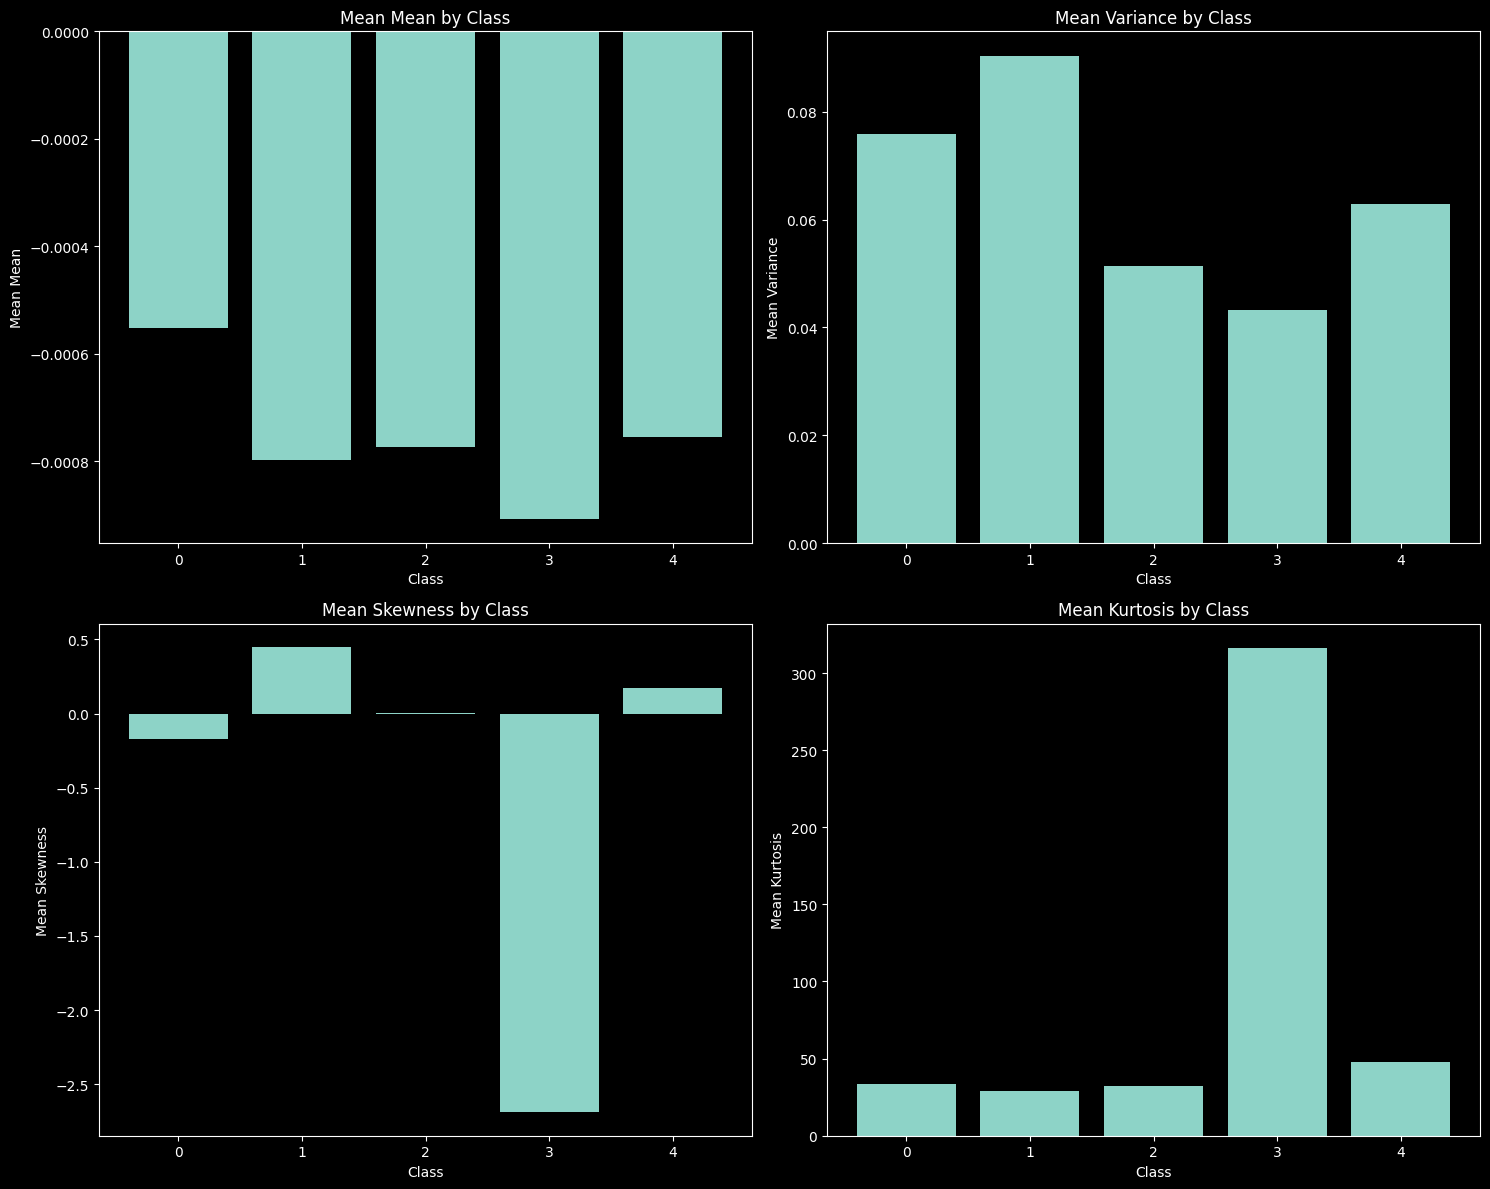

In [61]:
# Plot bar plots for mean values of each feature
plt.figure(figsize=(15, 12))

for i, feature in enumerate(['Mean', 'Variance', 'Skewness', 'Kurtosis']):
    plt.subplot(2, 2, i + 1)
    feature_means = features_df.groupby('Class')[feature].mean()
    plt.bar(feature_means.index, feature_means.values)
    plt.title(f'Mean {feature} by Class')
    plt.xlabel('Class')
    plt.ylabel(f'Mean {feature}')

plt.tight_layout()
plt.show()


This helps visualize how features are related within each class.

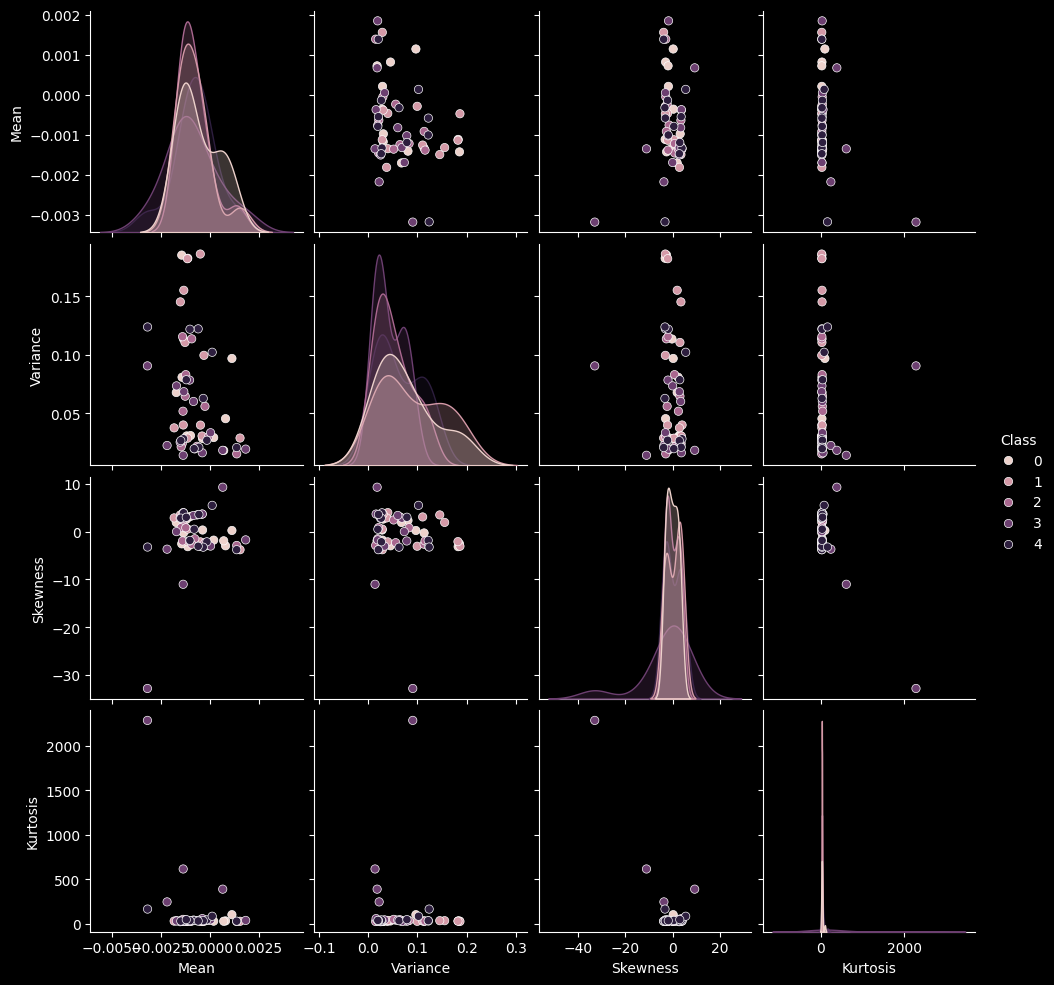

In [62]:
# For pair plots, you might want to flatten the features into a 2D DataFrame
flat_features = pd.DataFrame(np.array(features).reshape(-1, 4), columns=['Mean', 'Variance', 'Skewness', 'Kurtosis'])
flat_features['Class'] = np.repeat(range(num_classes), num_channels)

# Plot pair plots
sns.pairplot(flat_features, hue='Class')
plt.show()


This shows how different features are correlated with each other.

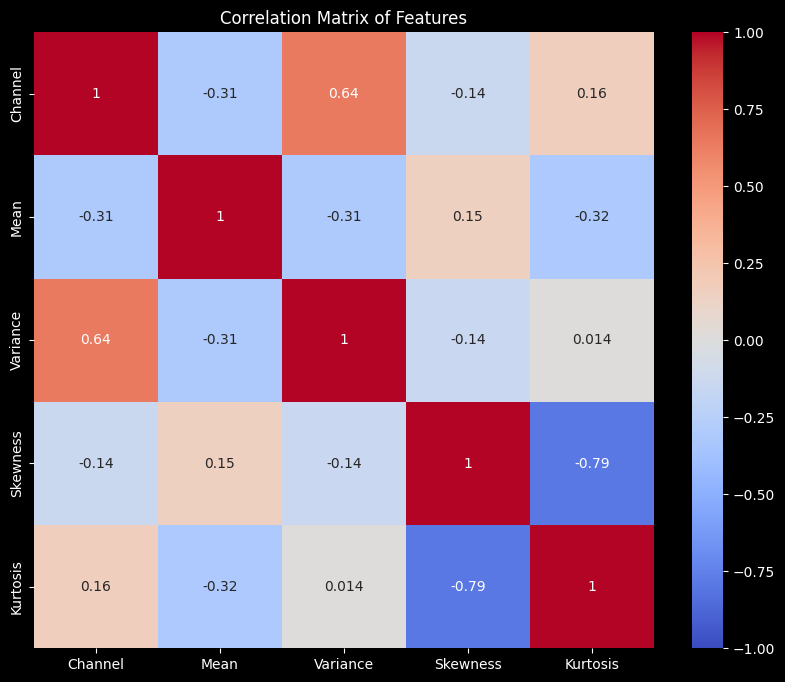

In [63]:
# Compute correlation matrix for features
features_corr = features_df.drop(columns='Class').corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(features_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()


## Architecture and training 

In [83]:
!pip install tensorflow

^C


   ---------------------------------------- 0.0/385.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/385.2 MB ? eta -:--:--
   ---------------------------------------- 0.8/385.2 MB 2.1 MB/s eta 0:03:04
   ---------------------------------------- 0.8/385.2 MB 2.1 MB/s eta 0:03:04
   ---------------------------------------- 1.3/385.2 MB 1.6 MB/s eta 0:04:01
   ---------------------------------------- 1.6/385.2 MB 1.7 MB/s eta 0:03:40
   ---------------------------------------- 2.1/385.2 MB 1.7 MB/s eta 0:03:42
   ---------------------------------------- 2.4/385.2 MB 1.7 MB/s eta 0:03:40
   ---------------------------------------- 2.9/385.2 MB 1.7 MB/s eta 0:03:39
   ---------------------------------------- 3.1/385.2 MB 1.8 MB/s eta 0:03:36
   ---------------------------------------- 3.7/385.2 MB 1.8 MB/s eta 0:03:36
   ---------------------------------------- 3.9/385.2 MB 1.7 MB/s eta 0:03:41
   ---------------------------------------- 3.9/385.2 MB 1.7 MB/s eta 0:03:41


In [84]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, Concatenate

ModuleNotFoundError: No module named 'tensorflow'

In [64]:




# Define CNN + RNN Hybrid Architecture
def build_hybrid_model(time_steps, num_channels, num_classes, precomputed_features_shape):
    # Input Layer for Raw ECG Signals
    ecg_input = Input(shape=(time_steps, num_channels), name='ecg_input')

    # CNN Layers for Spatial Feature Extraction
    x = Conv1D(filters=32, kernel_size=3, activation='relu')(ecg_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)  # Flatten CNN output to feed into LSTM and Dense layers

    # Input for Precomputed Features (statistical, FFT, etc.)
    feature_input = Input(shape=(precomputed_features_shape,), name='feature_input')

    # Concatenate CNN output with precomputed features
    concatenated = Concatenate()([x, feature_input])

    # LSTM Layers for Temporal Sequence Learning
    lstm_input = tf.expand_dims(concatenated, axis=1)  # Reshape concatenated features for LSTM
    lstm_out = LSTM(64, return_sequences=True)(lstm_input)
    lstm_out = LSTM(64)(lstm_out)

    # Fully Connected Layers
    fc = Dense(128, activation='relu')(lstm_out)
    fc = Dropout(0.5)(fc)  # Dropout for regularization

    # Output Layer
    output = Dense(num_classes, activation='softmax', name='output')(fc)

    # Build Model
    model = Model(inputs=[ecg_input, feature_input], outputs=output)

    # Compile Model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


(19601, 3)